<a href="https://colab.research.google.com/github/leahmashi/DL_HW1/blob/main/DL_HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

>>[Getting set up](#scrollTo=LWGihF7fykEC)

>>[Getting the images from kaggle](#scrollTo=vc5LQZwNP_ks)

>>[Exploring the data](#scrollTo=WQmshnpiRTmI)

>>>[Creating the dataset](#scrollTo=seOkaSAhxPgU)

>>>[Extracting metadata from dataset](#scrollTo=6gIqw44_QrA9)

>>>[handle unbalanced data](#scrollTo=_Z5Qzc3Gn0wA)

>>>[Benchmarks](#scrollTo=If0QvDpI9kEq)

>>>[Train-Test-Validation split](#scrollTo=iUAsi7oWoBxp)

>>>[Samples of each label](#scrollTo=F7YE9XGWyjun)

>>>[Harder to catch vs easier samples](#scrollTo=2k6nfDFLlDsB)

>>[Building our first neural network](#scrollTo=vpOHDvujSGOW)

>>>[Set up kfold cross validation](#scrollTo=N41YM97J07_G)

>>>[First CNN](#scrollTo=ZIzaoNTI6J_-)

>>>[Set up Neptune for first CNN](#scrollTo=YWV2eBVJa4Nw)

>>>[Get training labels](#scrollTo=dicYhDDZspvj)

>>>[Run kfold for first model](#scrollTo=Y8kXtP7K1c6L)

>>>[Comapring the data](#scrollTo=HE1Oc9hMgG7F)

>>>[Misclassification and ways to improve](#scrollTo=8ZQB4mFE1Svd)

>>[Trying to improve our first neural network](#scrollTo=m2--KDZ63lK8)

>>>[Set up Neptune for second CNN](#scrollTo=JffwoSY-OO36)

>>>[Changing the learning rate of the model](#scrollTo=AwC9kcHK6sO7)

>>>[Run k-fold second model](#scrollTo=72jGhctKmIsD)

>>>[Comapring the data](#scrollTo=0M-HAppe3dHS)

>>>[Misclassification and ways to improve](#scrollTo=TfhHWbvj3dHW)

>>>[Set up Neptune for third CNN](#scrollTo=nD60qTfzVuKr)

>>>[Changing the loss function + image size + more complex model](#scrollTo=ZZWJSaH4PYoX)

>>>[Run k-fold on third model](#scrollTo=fV0LmF_PnSDC)

>>>[Comapring the data](#scrollTo=GZ1rdK-nimcr)

>>>[Implementing inference-time-augmentation](#scrollTo=QS_hitXh5i0E)

>>>[Adding a new category](#scrollTo=OZsqUxDV54gF)

>>[Pretrained models](#scrollTo=IiXtP_-HyOgd)

>>>[Feature extraction](#scrollTo=3RDvxy2wKRhZ)



## Getting set up

In [1]:
# installs
!pip install lightning>=2.0
!pip install -U "neptune-client<1.0.0" pytorch-lightning --quiet
!pip install neptune-tensorflow-keras
!pip install neptune-contrib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 448.8/448.8 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 109.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.4/137.4 kB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.2/74.2 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for neptune-contri

In [2]:
# imports 
from google.colab import files
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import torch
from torch import nn, Generator, stack, tensor, argmax, optim, device, cuda, no_grad, cat, exp
from torch.utils.data import DataLoader, random_split, SubsetRandomSampler
from torchvision import datasets, transforms
from collections import Counter 
import lightning as L
from pytorch_lightning.callbacks import ModelCheckpoint
import torch.nn.functional as F
import tensorflow as tf
from torchmetrics import Accuracy
import torchmetrics
from torchvision import models
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from pytorch_lightning.loggers import NeptuneLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import neptune.new as neptune
from neptune.new.integrations.tensorflow_keras import NeptuneCallback
import pandas as pd
import time
from prettytable import PrettyTable

## Getting the images from kaggle

In [3]:
# connecting to local file system to upload authorization file (for downloading from kaggle)
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [4]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
! kaggle datasets download -d lantian773030/pokemonclassification

100% 416M/417M [00:13<00:00, 28.2MB/s]
100% 417M/417M [00:13<00:00, 33.6MB/s]


In [6]:
!unzip /content/pokemonclassification.zip

Streaming output truncated to the last 5000 lines.
  inflating: PokemonData/Golbat/78bb8cd2828f40158fc0dcd4c0366a57.jpg  
  inflating: PokemonData/Golbat/7b7a064d3a1b4c53a9be936d4e4e3bab.jpg  
  inflating: PokemonData/Golbat/7d07fd6776fb40e9986a1a0f62233325.jpg  
  inflating: PokemonData/Golbat/815b279060b94e12a6b35d434a5250c2.jpg  
  inflating: PokemonData/Golbat/818014085ff04885b31eb5e8737012f2.jpg  
  inflating: PokemonData/Golbat/87529331a47b4a5cb5d10a6b3ea46d84.jpg  
  inflating: PokemonData/Golbat/914fab74d32e49a98940d5ba7f674fa6.jpg  
  inflating: PokemonData/Golbat/949a05bd0ad44be993e5fd89a8f582df.jpg  
  inflating: PokemonData/Golbat/9a4c793b9b0042a99ebd540897f9f898.jpg  
  inflating: PokemonData/Golbat/a35b4e8e603c485cb197520af30e1208.jpg  
  inflating: PokemonData/Golbat/a45a14a67a7348bba57c06467bb73cde.jpg  
  inflating: PokemonData/Golbat/acc2b44eada74a25a64c041b2e80c453.jpg  
  inflating: PokemonData/Golbat/af30483e382240d38890dec39e083b08.jpg  
  inflating: PokemonData/G

## Exploring the data

### Creating the dataset

In [ ]:
BATCH_SIZE = 64

imagenet_data = datasets.ImageFolder("/content/PokemonData", transform=transforms.ToTensor())

### Extracting metadata from dataset

In [ ]:
# dataset size
DATA_SIZE = len(imagenet_data)

In [ ]:
# sample the data
for i in range(0,5):
  n = random.randint(0, DATA_SIZE)
  xn, yn = imagenet_data[n]
  print(n, "sample: ", xn.shape)

1322 sample:  torch.Size([3, 142, 142])
4022 sample:  torch.Size([3, 95, 95])
1563 sample:  torch.Size([3, 156, 157])
4823 sample:  torch.Size([3, 598, 608])
6122 sample:  torch.Size([3, 1268, 1413])


From the cell above we can see that all pictures have 3 channels (red, green and blue)\
but the dimensions are different. Therefore we need to resize the images:


In [26]:
imagenet_data = datasets.ImageFolder("/content/PokemonData", transform=transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
]))

In [ ]:
# size of dataset
print("dataset size: ", len(imagenet_data))

# sample the data
print("check the pictures are from the same dimensions: ")
for i in range(0,5):
  n = random.randint(0, DATA_SIZE)
  xn, yn = imagenet_data[n]
  print(n, "sample: ", xn.shape)

# number of classes
print("number of classes: ", len(imagenet_data.classes))

# number of examples per class
print("number of examples per class: ")
counts = dict(Counter(imagenet_data.targets))
labels = imagenet_data.class_to_idx
y_dictionary = {label : counts[labels[label]] for label  in labels}
print(y_dictionary)

dataset size:  6820
check the pictures are from the same dimensions: 
2489 sample:  torch.Size([3, 150, 150])
5111 sample:  torch.Size([3, 150, 150])
1227 sample:  torch.Size([3, 150, 150])
5190 sample:  torch.Size([3, 150, 150])
6665 sample:  torch.Size([3, 150, 150])
number of classes:  150
number of examples per class: 
{'Abra': 35, 'Aerodactyl': 35, 'Alakazam': 26, 'Alolan Sandslash': 41, 'Arbok': 41, 'Arcanine': 41, 'Articuno': 45, 'Beedrill': 34, 'Bellsprout': 40, 'Blastoise': 42, 'Bulbasaur': 41, 'Butterfree': 27, 'Caterpie': 37, 'Chansey': 43, 'Charizard': 35, 'Charmander': 51, 'Charmeleon': 46, 'Clefable': 38, 'Clefairy': 46, 'Cloyster': 48, 'Cubone': 40, 'Dewgong': 43, 'Diglett': 39, 'Ditto': 40, 'Dodrio': 39, 'Doduo': 35, 'Dragonair': 42, 'Dragonite': 48, 'Dratini': 26, 'Drowzee': 39, 'Dugtrio': 51, 'Eevee': 37, 'Ekans': 35, 'Electabuzz': 41, 'Electrode': 51, 'Exeggcute': 46, 'Exeggutor': 50, 'Farfetchd': 48, 'Fearow': 48, 'Flareon': 45, 'Gastly': 44, 'Gengar': 49, 'Geodude'

we can see from the cell above that the data is unbalanced

### handle unbalanced data

There are multiple things we need to keep in mind when handling unbalanced data:
*   since our data is unbalanced we will have to look at different evaluation metrics (other than accuracy) such as: precision, recall, F1 score, AUC.
*   we can choose to undersample/oversample the dataset, creating the same amount of samples in each class
*   we will have to use k-fold cross-validation with the right method: stratisfied k-fold cross-validation.

### Benchmarks

We only found one benchmark that displays an F1 score of 90% utilizing a DenseNet201 model - https://www.kaggle.com/code/quadeer15sh/classification-and-pokemon-api-90-f1-score 

### Train-Test-Validation split


In [27]:
train, test = random_split(imagenet_data, [0.8, 0.2], Generator().manual_seed(42))

In [ ]:
print("train sample size: ", len(train))
print("train features size: ", train[0][0].shape)

train sample size:  5456
train features size:  torch.Size([3, 150, 150])


In [ ]:
print("test sample size: ", len(test))
print("test features size: ", test[0][0].shape)

test sample size:  1364
test features size:  torch.Size([3, 150, 150])


our data consists of 5456 training samples and 1364 test samples

### Samples of each label

In [ ]:
def imshow(img):
    plt.imshow(np.transpose(img, (1,2,0))) #convert tensor image type to numpy image type for visualization

In [ ]:
def multi_imshow(pic_amount, images, labels, rows=3, cols=7, preds = None):
  fig = plt.figure(figsize=(10,10))
  for idx in np.arange(pic_amount):
      ax = fig.add_subplot(rows, cols, idx+1, xticks=[], yticks=[])
      imshow(images[idx])
      ax.set_title(imagenet_data.classes[labels[idx]])
      if preds is not None:
        ax.set_xlabel(preds[idx])
        if preds[idx] == imagenet_data.classes[labels[idx]]:
          ax.xaxis.label.set_color('green')
        else:
          ax.xaxis.label.set_color('red')

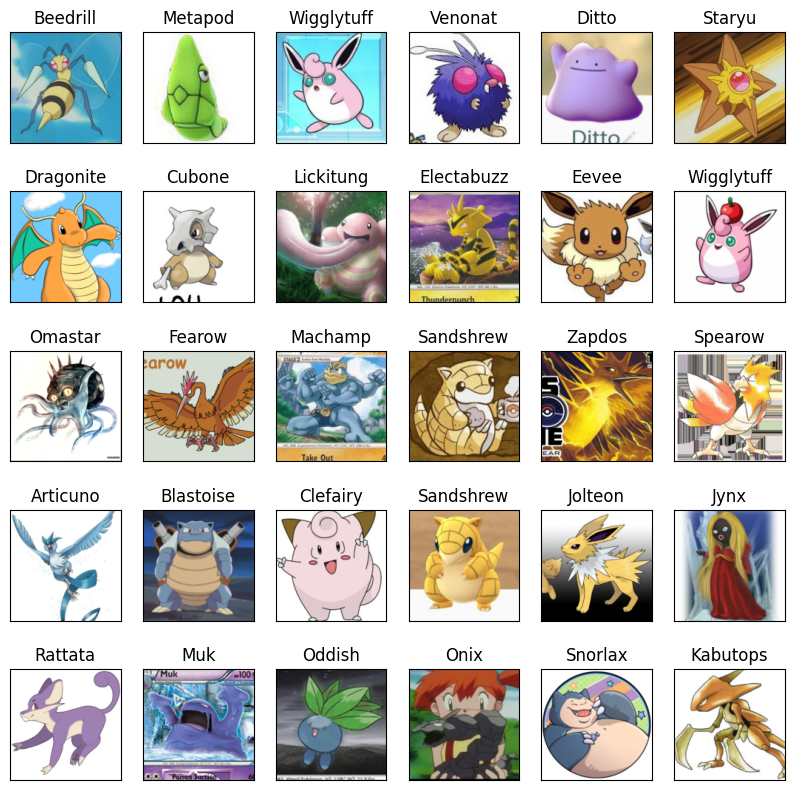

In [ ]:
# visualize some sample data

# create a data loader
train_loader = DataLoader(train, batch_size=32, shuffle=True)

# obtain one batch of training images
images, labels = next(iter(train_loader))
images = images.numpy() #convert images to numpy for display

# plot the images in the batch, along with corresponding labels
multi_imshow(30, images, labels, rows=5, cols=6)

### Harder to catch vs easier samples
Electrode & Voltorb:

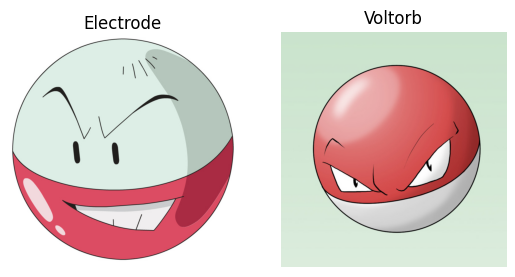

In [ ]:
plt.subplot(1,2,1)
img1 = mpimg.imread("/content/PokemonData/Electrode/1b11103a2d1f4e289434494b9dee3ab9.jpg")
plt.imshow(img1)
plt.title("Electrode")
plt.axis('off')

plt.subplot(1,2,2)
img2 = mpimg.imread("/content/PokemonData/Voltorb/123478ad2e72491b967d4a2bd8626381.jpg")
plt.imshow(img2)
plt.title("Voltorb")
plt.axis('off')

plt.show()

Abra & Kadabra & Alkazam:

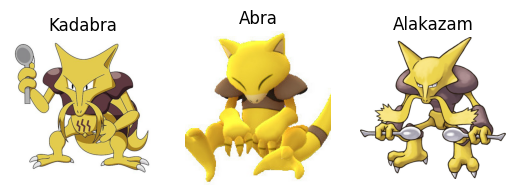

In [ ]:
plt.subplot(1,3,1)
img1 = mpimg.imread("/content/PokemonData/Kadabra/079a7ad0d3494c129ab8f8079eb6a2a9.jpg")
plt.imshow(img1)
plt.title("Kadabra")
plt.axis('off')

plt.subplot(1,3,2)
img2 = mpimg.imread("/content/PokemonData/Abra/2eb2a528f9a247358452b3c740df69a0.jpg")
plt.imshow(img2)
plt.title("Abra")
plt.axis('off')

plt.subplot(1,3,3)
img3 = mpimg.imread("/content/PokemonData/Alakazam/30bb8818f4574e319d59835d98dc5959.jpg")
plt.imshow(img3)
plt.title("Alakazam")
plt.axis('off')

plt.show()

Alolan sandslash & Sandslash:

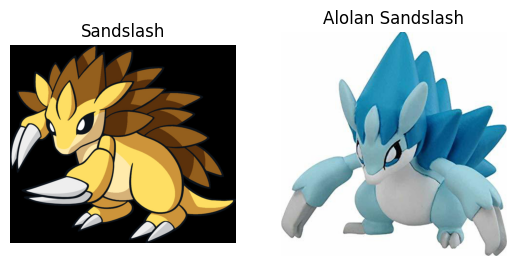

In [ ]:
plt.subplot(1,2,1)
img1 = mpimg.imread("/content/PokemonData/Sandslash/58edff9452ba45a880c786e464b94e47.jpg")
plt.imshow(img1)
plt.title("Sandslash")
plt.axis('off')

plt.subplot(1,2,2)
img2 = mpimg.imread("/content/PokemonData/Alolan Sandslash/f0d445d4edef499eb9e9ae2ff67b518c.jpg")
plt.imshow(img2)
plt.title("Alolan Sandslash")
plt.axis('off')

plt.show()

some samples that might be easier:

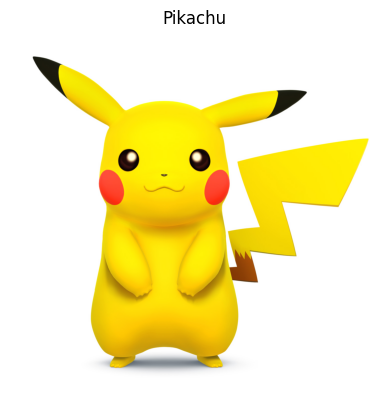

In [ ]:
img = mpimg.imread("/content/PokemonData/Pikachu/00000004.jpg")
plt.imshow(img)
plt.title("Pikachu")
plt.axis('off')
plt.show()

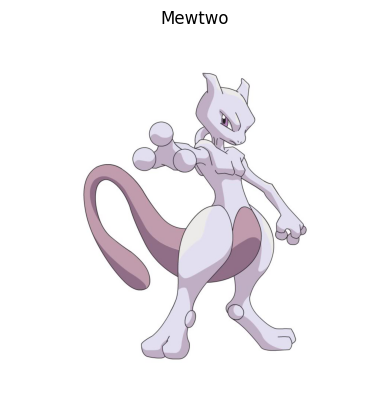

In [ ]:
img = mpimg.imread("/content/PokemonData/Mewtwo/00000000.jpg")
plt.imshow(img)
plt.title("Mewtwo")
plt.axis('off')
plt.show()

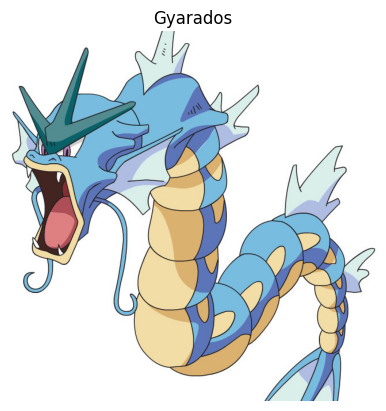

In [ ]:
img = mpimg.imread("/content/PokemonData/Gyarados/42c6a154850848888b6fc1d3279946a8.jpg")
plt.imshow(img)
plt.title("Gyarados")
plt.axis('off')
plt.show()

## Building our first neural network

### Set up kfold cross validation

In [28]:
def reset_weights(m):
  '''
    Try resetting model weights to avoid
    weight leakage.
  '''
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()

In [29]:
K = 5
EPOCHS = 10
BATCH_SIZE = 32

stratified_kfold = StratifiedKFold(n_splits=K, shuffle=True)

def cross_validation(train_dataset, test_dataset, labels, model, neptune_logger):
  # create dictionary of data for later
  accuracies_and_losses = {
      'test_accuracies': [],
      'test_losses': [],
      'train_accuracies': [],
      'train_losses': [],
      'val_accuracies': [],
      'val_losses': [],
  }

  for fold, (train_ids, valid_ids) in enumerate(stratified_kfold.split(train_dataset, labels)):
    print("----------------------------------------")
    print("fold ", fold)
    print("----------------------------------------")

    # clear weights from previous fold
    model.apply(reset_weights)

    # create subsets of train and validate samples
    train_subsampler = SubsetRandomSampler(train_ids)
    val_subsampler = SubsetRandomSampler(valid_ids)

    # create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_subsampler)
    val_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=val_subsampler)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

    # train the model
    trainer = L.Trainer(max_epochs=EPOCHS,
                        logger=neptune_logger,
                        enable_model_summary=True,
                        )
    trainer.current_fold = fold
    trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

    # get training and validation losses and accuracies
    train_loss = trainer.callback_metrics[f'training/{trainer.current_fold}/loss']
    val_loss = trainer.callback_metrics[f'validation/{trainer.current_fold}/val_loss']
    train_acc = trainer.callback_metrics[f'training/{trainer.current_fold}/train_acc']
    val_acc = trainer.callback_metrics[f'validation/{trainer.current_fold}/val_acc']
    
    trainer.test(model, dataloaders=test_loader)
    
    test_loss = trainer.callback_metrics[f'test/{trainer.current_fold}/test_loss']
    test_acc = trainer.callback_metrics[f'test/{trainer.current_fold}/test_acc']

    print("----------------------------------------")
    print("train loss: ", train_loss)
    print("train accuracy: ", train_acc)
    print("validation loss: ", val_loss)
    print("validation accuracy: ", val_acc)
    print("test loss: ", test_loss)
    print("test accuracy: ", test_acc)
    print("----------------------------------------")

    accuracies_and_losses['test_accuracies'].append(test_acc)
    accuracies_and_losses['test_losses'].append(test_loss)
    accuracies_and_losses['train_accuracies'].append(train_acc)
    accuracies_and_losses['train_losses'].append(train_loss)
    accuracies_and_losses['val_accuracies'].append(val_acc)
    accuracies_and_losses['val_losses'].append(val_loss)

  return accuracies_and_losses

### First CNN

In [30]:
data_path = ""

class CNN_Pokemon(L.LightningModule):
    def __init__(self, data_dir=data_path, num_classes=150, learning_rate=1e-4):
        super().__init__()

        # Set our init args as class attributes
        self.data_dir = data_dir
        self.learning_rate = learning_rate

        # Hardcode some dataset specific attributes
        self.num_classes = num_classes
        self.conv1 = nn.Conv2d(3,32,3,padding='same') 
        ## input channels 3 for rgb 
        ## output channels 32 - as the number of filters that we train
        ## kernel size 3 - arbitrary selection
        self.conv2 = nn.Conv2d(32,64,3,padding='same')
        self.conv3 = nn.Conv2d(64,128,3,padding='same')
        self.conv4 = nn.Conv2d(128,256,3,padding='same')
        self.linear1 = nn.Linear(256*37*37,300)
        self.linear2 = nn.Linear(300,self.num_classes)
        self.mp = nn.MaxPool2d(2,2)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.train_accuracy = torchmetrics.classification.F1Score(task="multiclass", num_classes=self.num_classes)
        self.val_accuracy = torchmetrics.classification.F1Score(task="multiclass", num_classes=self.num_classes)
        self.test_accuracy = torchmetrics.classification.F1Score(task="multiclass", num_classes=self.num_classes)


    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.mp(x)
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.mp(x)
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.linear2(x)
        return F.log_softmax(x, dim=1)

    def training_step(self, batch, batch_idx): 
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = argmax(logits, dim=1)
        self.train_accuracy.update(preds, y)
        self.log(f'training/{self.trainer.current_fold}/loss', loss, on_epoch=True, on_step=True)
        self.log(f'training/{self.trainer.current_fold}/train_acc', self.train_accuracy, on_epoch=True, on_step=True)
        return {'loss': loss, 'train_acc': self.train_accuracy.compute()} 

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = argmax(logits, dim=1)
        self.val_accuracy.update(preds, y)
        self.log(f'validation/{self.trainer.current_fold}/val_loss', loss, on_epoch=True, on_step=True)
        self.log(f'validation/{self.trainer.current_fold}/val_acc', self.val_accuracy, on_epoch=True, on_step=True)
        return {'val_loss': loss, 'val_acc': self.val_accuracy.compute()}       

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = argmax(logits, dim=1)
        self.test_accuracy.update(preds, y)
        self.log(f'test/{self.trainer.current_fold}/test_loss', loss, on_epoch=True, on_step=True)
        self.log(f'test/{self.trainer.current_fold}/test_acc', self.test_accuracy, on_epoch=True, on_step=True)
        return {'test_loss': loss, 'test_acc': self.test_accuracy.compute()}

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

### Set up Neptune for first CNN

In [31]:
hyperParameters = {
            'max_epochs':EPOCHS,
            'batch_size':BATCH_SIZE,
            'learning_rate':1e-4,
            'image_size': '150*150'
        }

In [32]:
neptune_logger = NeptuneLogger(
        api_key='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vbmV3LXVpLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9uZXctdWkubmVwdHVuZS5haSIsImFwaV9rZXkiOiIxYTUwNmZiMi1lNWI1LTRhM2MtOWIyMS1mZDhhYTZjMTg5MmEifQ==',
        project="Deep-Learning-Projects/Pokemon-Data",
        log_model_checkpoints=False,     
    )

In [33]:
neptune_logger.log_hyperparams(hyperParameters)

https://new-ui.neptune.ai/Deep-Learning-Projects/Pokemon-Data/e/POK-145
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


### Get training labels

In [34]:
def get_features_labels(data):
  features = []
  labels = []
  for i in range(len(data)):
    features_n, _ = data[i]
    features.append(features_n)
    label_n = data[i][1]
    labels.append(label_n)
  features_tensor = stack(features)
  labels_tensor = tensor(labels)
  return features_tensor, labels_tensor

In [35]:
features_and_labels = get_features_labels(train)

In [36]:
features_tensor = features_and_labels[0]
labels_tensor = features_and_labels[1]

### Run kfold for first model

In [37]:
model = CNN_Pokemon(num_classes=151)
accuracies_and_losses = cross_validation(train, test, labels_tensor, model, neptune_logger)

----------------------------------------
fold  0
----------------------------------------
Reset trainable parameters of layer = Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
Reset trainable parameters of layer = Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
Reset trainable parameters of layer = Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
Reset trainable parameters of layer = Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
Reset trainable parameters of layer = Linear(in_features=350464, out_features=300, bias=True)
Reset trainable parameters of layer = Linear(in_features=300, out_features=151, bias=True)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name           | Type              | Params
------------------------------------------------------
0  | conv1          | Conv2d            | 896   
1  | conv2          | Conv2d            | 18.5 K
2  | conv3          | Conv2d            | 73.9 K
3  | conv4          | Conv2d            | 295 K 
4  | linear1        | Linear            | 105 M 
5  | linear2        | Linear            | 45.5 K
6  | mp             | MaxPool2d         | 0     
7  | relu           | ReLU              | 0     
8  | flatten        | Flatten           | 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   test/0/test_acc_epoch   │    0.4915997087955475     │
│  test/0/test_loss_epoch   │    3.0917105674743652     │
└───────────────────────────┴───────────────────────────┘

----------------------------------------
train loss:  tensor(0.0330)
train accuracy:  tensor(0.9943)
validation loss:  tensor(3.0028)
validation accuracy:  tensor(0.5182)
test loss:  tensor(3.0917)
test accuracy:  tensor(0.4916)
----------------------------------------
----------------------------------------
fold  1
----------------------------------------
Reset trainable parameters of layer = Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
Reset trainable parameters of layer = Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
Reset trainable parameters of layer = Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
Reset trainable parameters of layer = Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
Reset trainable parameters of layer = Linear(in_features=350464, out_features=300, bias=True)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Reset trainable parameters of layer = Linear(in_features=300, out_features=151, bias=True)


/usr/local/lib/python3.9/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory /content/.neptune/Untitled/POK-145/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name           | Type              | Params
------------------------------------------------------
0  | conv1          | Conv2d            | 896   
1  | conv2          | Conv2d            | 18.5 K
2  | conv3          | Conv2d            | 73.9 K
3  | conv4          | Conv2d            | 295 K 
4  | linear1        | Linear            | 105 M 
5  | linear2        | Linear            | 45.5 K
6  | mp             | MaxPool2d         | 0     
7  | relu           | ReLU              | 0     
8  | flatten        | Flatten           | 0     
9  | train_accuracy | MulticlassF1Score | 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   test/1/test_acc_epoch   │    0.5018261671066284     │
│  test/1/test_loss_epoch   │    3.0187759399414062     │
└───────────────────────────┴───────────────────────────┘

----------------------------------------
train loss:  tensor(0.0448)
train accuracy:  tensor(0.9948)
validation loss:  tensor(3.0864)
validation accuracy:  tensor(0.4776)
test loss:  tensor(3.0188)
test accuracy:  tensor(0.5018)
----------------------------------------
----------------------------------------
fold  2
----------------------------------------
Reset trainable parameters of layer = Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
Reset trainable parameters of layer = Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
Reset trainable parameters of layer = Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
Reset trainable parameters of layer = Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
Reset trainable parameters of layer = Linear(in_features=350464, out_features=300, bias=True)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Reset trainable parameters of layer = Linear(in_features=300, out_features=151, bias=True)


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name           | Type              | Params
------------------------------------------------------
0  | conv1          | Conv2d            | 896   
1  | conv2          | Conv2d            | 18.5 K
2  | conv3          | Conv2d            | 73.9 K
3  | conv4          | Conv2d            | 295 K 
4  | linear1        | Linear            | 105 M 
5  | linear2        | Linear            | 45.5 K
6  | mp             | MaxPool2d         | 0     
7  | relu           | ReLU              | 0     
8  | flatten        | Flatten           | 0     
9  | train_accuracy | MulticlassF1Score | 0     
10 | val_accuracy   | MulticlassF1Score | 0     
11 | test_accuracy  | MulticlassF1Score | 0     
------------------------------------------------------
105 M     Trainable params
0         Non-trainable params
105 M     Total params
422.293   Total estimated model pa

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   test/2/test_acc_epoch   │    0.4645726680755615     │
│  test/2/test_loss_epoch   │     3.361530065536499     │
└───────────────────────────┴───────────────────────────┘

----------------------------------------
train loss:  tensor(0.0815)
train accuracy:  tensor(0.9838)
validation loss:  tensor(3.1410)
validation accuracy:  tensor(0.4767)
test loss:  tensor(3.3615)
test accuracy:  tensor(0.4646)
----------------------------------------
----------------------------------------
fold  3
----------------------------------------
Reset trainable parameters of layer = Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
Reset trainable parameters of layer = Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
Reset trainable parameters of layer = Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
Reset trainable parameters of layer = Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
Reset trainable parameters of layer = Linear(in_features=350464, out_features=300, bias=True)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Reset trainable parameters of layer = Linear(in_features=300, out_features=151, bias=True)


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name           | Type              | Params
------------------------------------------------------
0  | conv1          | Conv2d            | 896   
1  | conv2          | Conv2d            | 18.5 K
2  | conv3          | Conv2d            | 73.9 K
3  | conv4          | Conv2d            | 295 K 
4  | linear1        | Linear            | 105 M 
5  | linear2        | Linear            | 45.5 K
6  | mp             | MaxPool2d         | 0     
7  | relu           | ReLU              | 0     
8  | flatten        | Flatten           | 0     
9  | train_accuracy | MulticlassF1Score | 0     
10 | val_accuracy   | MulticlassF1Score | 0     
11 | test_accuracy  | MulticlassF1Score | 0     
------------------------------------------------------
105 M     Trainable params
0         Non-trainable params
105 M     Total params
422.293   Total estimated model pa

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   test/3/test_acc_epoch   │    0.4623813033103943     │
│  test/3/test_loss_epoch   │    3.0023491382598877     │
└───────────────────────────┴───────────────────────────┘

----------------------------------------
train loss:  tensor(0.0342)
train accuracy:  tensor(0.9959)
validation loss:  tensor(3.0845)
validation accuracy:  tensor(0.4667)
test loss:  tensor(3.0023)
test accuracy:  tensor(0.4624)
----------------------------------------
----------------------------------------
fold  4
----------------------------------------
Reset trainable parameters of layer = Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
Reset trainable parameters of layer = Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
Reset trainable parameters of layer = Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
Reset trainable parameters of layer = Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
Reset trainable parameters of layer = Linear(in_features=350464, out_features=300, bias=True)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Reset trainable parameters of layer = Linear(in_features=300, out_features=151, bias=True)


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name           | Type              | Params
------------------------------------------------------
0  | conv1          | Conv2d            | 896   
1  | conv2          | Conv2d            | 18.5 K
2  | conv3          | Conv2d            | 73.9 K
3  | conv4          | Conv2d            | 295 K 
4  | linear1        | Linear            | 105 M 
5  | linear2        | Linear            | 45.5 K
6  | mp             | MaxPool2d         | 0     
7  | relu           | ReLU              | 0     
8  | flatten        | Flatten           | 0     
9  | train_accuracy | MulticlassF1Score | 0     
10 | val_accuracy   | MulticlassF1Score | 0     
11 | test_accuracy  | MulticlassF1Score | 0     
------------------------------------------------------
105 M     Trainable params
0         Non-trainable params
105 M     Total params
422.293   Total estimated model pa

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   test/4/test_acc_epoch   │    0.4762600362300873     │
│  test/4/test_loss_epoch   │     3.422255516052246     │
└───────────────────────────┴───────────────────────────┘

----------------------------------------
train loss:  tensor(0.0322)
train accuracy:  tensor(0.9934)
validation loss:  tensor(3.2501)
validation accuracy:  tensor(0.4986)
test loss:  tensor(3.4223)
test accuracy:  tensor(0.4763)
----------------------------------------


In [38]:
neptune_logger.experiment.stop()

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 3 operations to synchronize with Neptune. Do not kill this process.
All 3 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://new-ui.neptune.ai/Deep-Learning-Projects/Pokemon-Data/e/POK-145


In [ ]:
# save the model
torch.save(model.state_dict(), 'CNN_Pokemon.pth')

### Comapring the data

In [ ]:
run = neptune.init_run(api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vbmV3LXVpLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9uZXctdWkubmVwdHVuZS5haSIsImFwaV9rZXkiOiIxYTUwNmZiMi1lNWI1LTRhM2MtOWIyMS1mZDhhYTZjMTg5MmEifQ==',
        project="Deep-Learning-Projects/Pokemon-Data",
        with_id="POK-113")

https://new-ui.neptune.ai/Deep-Learning-Projects/Pokemon-Data/e/POK-113
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [ ]:
validation_acc_data = run["training/validation/1/val_acc_epoch"].fetch_values(include_timestamp=False)
training_acc_data = run["training/training/1/train_acc_epoch"].fetch_values(include_timestamp=False)

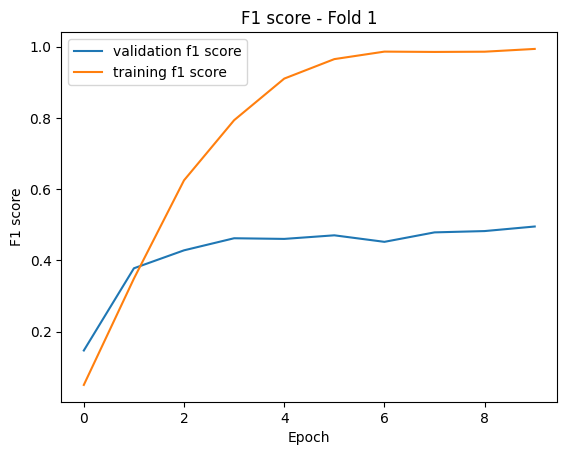

In [ ]:
plt.plot(validation_acc_data['value'], label='validation f1 score')
plt.plot(training_acc_data['value'], label='training f1 score')
plt.xlabel('Epoch')
plt.ylabel('F1 score')
plt.title('F1 score - Fold 1')
plt.legend()
plt.show()

In [ ]:
validation_loss_data = run["training/validation/1/val_loss_epoch"].fetch_values(include_timestamp=False)
training_loss_data = run["training/training/1/loss_epoch"].fetch_values(include_timestamp=False)

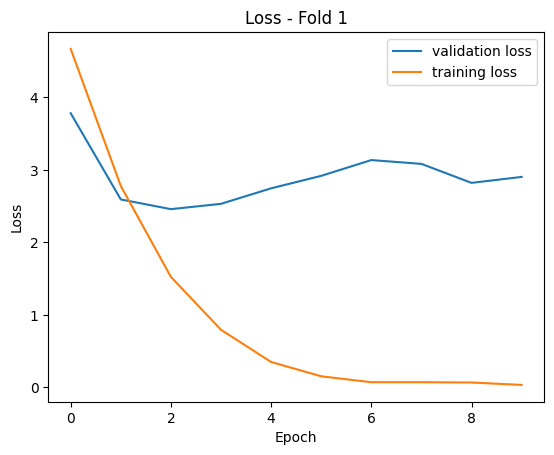

In [ ]:
plt.plot(validation_loss_data['value'], label='validation loss')
plt.plot(training_loss_data['value'], label='training loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss - Fold 1')
plt.legend()
plt.show()

Examples of good and bad samples:

In [ ]:
# Mount your Google Drive in Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# load the saved model
saved_model = CNN_Pokemon()
saved_model.load_state_dict(torch.load('/content/drive/MyDrive/models/CNN_Pokemon.pth'))

<All keys matched successfully>

In [ ]:
def get_correct_incorrect(loader, model, threshold=0.8):
  correct_preds = []
  incorrect_preds = []

  for images, labels in loader:
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    probabilities = F.softmax(outputs.data, dim=1)
    max_probabilities, _ = torch.max(probabilities, 1)

    for i, (pred, probability) in enumerate(zip(predicted, max_probabilities)):
      if probability >= threshold and pred == labels[i]:
        correct_preds.append((images[i], pred, labels[i], probability))

    for i, (pred, probability) in enumerate(zip(predicted, max_probabilities)):
      if probability >= threshold and pred != labels[i]:
        incorrect_preds.append((images[i], pred, labels[i], probability))
  return correct_preds, incorrect_preds

In [ ]:
test_loader = DataLoader(test, batch_size=BATCH_SIZE)
correct_preds, incorrect_preds = get_correct_incorrect(test_loader, saved_model)

In [ ]:
# Visualize the correct and incorrect predictions
def visualize_correct_incorrect(correct_preds, incorrect_preds):
  fig, axs = plt.subplots(2, 5, figsize=(15, 6))
  # flatten 2D array to 1D array
  axs = axs.ravel()

  # Plot correct predictions
  for i in range(5):
      axs[i].imshow(transforms.ToPILImage()(correct_preds[i][0]))
      pred = imagenet_data.classes[correct_preds[i][1]]
      label = imagenet_data.classes[correct_preds[i][2]]
      axs[i].set_xlabel(pred + ", real: " + label)
      axs[i].set_ylabel(correct_preds[i][3])
      axs[i].xaxis.label.set_color('green')
      axs[i].set_xticks([])
      axs[i].set_yticks([])
      axs[i].set_title('Correct Prediction')

  # Plot incorrect predictions
  for i in range(5):
      axs[i+5].imshow(transforms.ToPILImage()(incorrect_preds[i][0]))
      pred = imagenet_data.classes[incorrect_preds[i][1]]
      label = imagenet_data.classes[incorrect_preds[i][2]]
      axs[i+5].set_xlabel(pred + ", real: " + label)
      axs[i+5].set_ylabel(incorrect_preds[i][3])
      axs[i+5].xaxis.label.set_color('red')
      axs[i+5].set_xticks([])
      axs[i+5].set_yticks([])
      axs[i+5].set_title('Incorrect Prediction')

  plt.show()

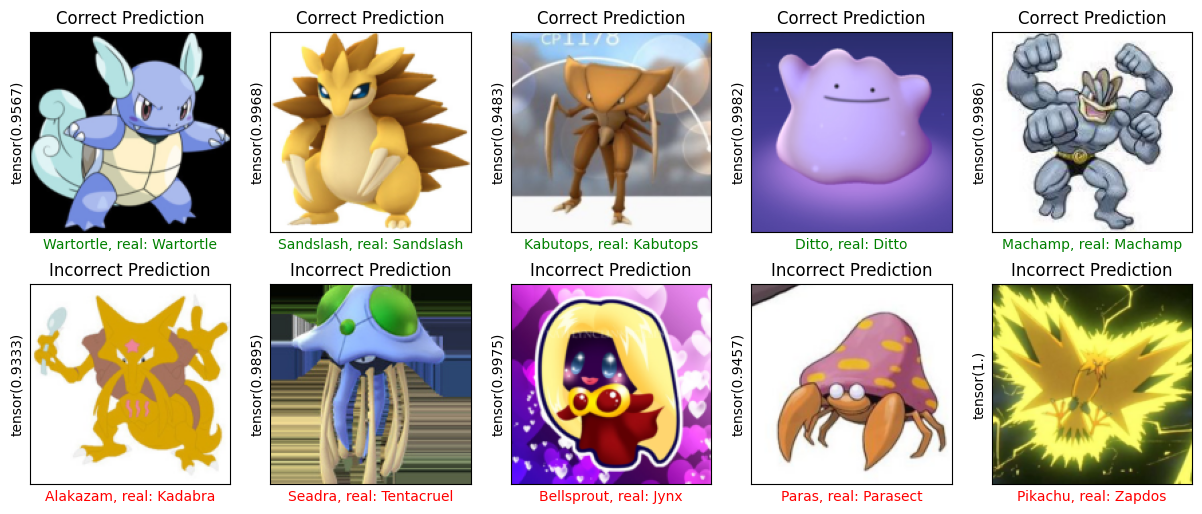

In [ ]:
visualize_correct_incorrect(correct_preds, incorrect_preds)

In [ ]:
def visualize_measures(run):
  for i in range(K):
    validation_acc_data = run[f"training/validation/{i}/val_acc_epoch"].fetch_values(include_timestamp=False)
    print(f"---fold {i} validation f1 score---")
    print(validation_acc_data)
    train_acc_data = run[f"training/training/{i}/train_acc_epoch"].fetch_values(include_timestamp=False)
    print(f"---fold {i} training f1 score---")
    print(train_acc_data)
    train_loss_data = run[f"training/training/{i}/loss_epoch"].fetch_values(include_timestamp=False)
    print(f"---fold {i} training loss---")
    print(train_loss_data)
    validation_loss_data = run[f"training/validation/{i}/val_loss_epoch"].fetch_values(include_timestamp=False)
    print(f"---fold {i} validation loss---")
    print(validation_loss_data)

In [ ]:
visualize_measures(run)

---fold 0 validation f1 score---
   step     value
0   0.0  0.119048
1   1.0  0.279304
2   2.0  0.390110
3   3.0  0.426740
4   4.0  0.433150
5   5.0  0.431319
6   6.0  0.433150
7   7.0  0.435897
8   8.0  0.452381
9   9.0  0.445055
---fold 0 training f1 score---
   step     value
0   0.0  0.043767
1   1.0  0.263520
2   2.0  0.548121
3   3.0  0.815078
4   4.0  0.944546
5   5.0  0.984876
6   6.0  0.986480
7   7.0  0.995646
8   8.0  0.997708
9   9.0  0.999542
---fold 0 training loss---
   step     value
0   0.0  4.660457
1   1.0  3.278931
2   2.0  1.890886
3   3.0  0.752517
4   4.0  0.223596
5   5.0  0.073335
6   6.0  0.064344
7   7.0  0.024276
8   8.0  0.015766
9   9.0  0.003747
---fold 0 validation loss---
   step     value
0   0.0  4.095445
1   1.0  3.105866
2   2.0  2.516042
3   3.0  2.657076
4   4.0  2.814259
5   5.0  3.097032
6   6.0  3.249665
7   7.0  3.454500
8   8.0  3.328929
9   9.0  3.399534
---fold 1 validation f1 score---
   step     value
0   0.0  0.146654
1   1.0  0.377635
2

In [ ]:
test_accuracy_folds = []
for i in range(K):
  test_accuracy_fold = run[f"training/test/{i}/test_acc_epoch"].fetch_values(include_timestamp=False)
  test_accuracy_folds.append(test_accuracy_fold['value'][0])

In [ ]:
test_accuracy_mean = sum(test_accuracy_folds)/len(test_accuracy_folds)

In [ ]:
test_accuracy_mean

0.47785924077034

In [ ]:
test_accuracy_folds.append(test_accuracy_mean)

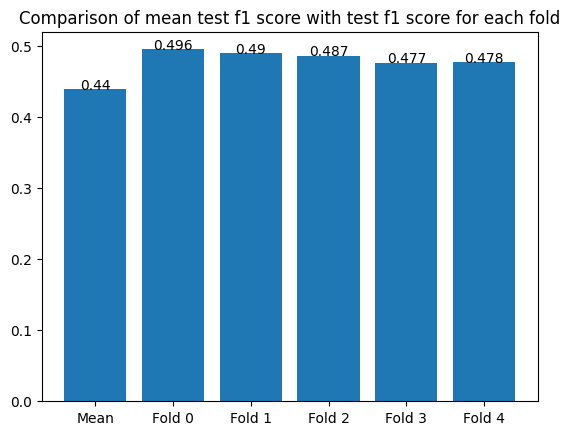

In [ ]:
plt.bar(['Mean', 'Fold 0', 'Fold 1', 'Fold 2', 'Fold 3', 'Fold 4'], test_accuracy_folds)
plt.title('Comparison of mean test f1 score with test f1 score for each fold')
for i in range(len(test_accuracy_folds)):
  plt.text(i,test_accuracy_folds[i],round(test_accuracy_folds[i], 3), ha='center')
plt.show()

In [ ]:
run.stop()

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
All 1 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://new-ui.neptune.ai/Deep-Learning-Projects/Pokemon-Data/e/POK-113


### Misclassification and ways to improve

In [ ]:
def evaluate_model(loader, model):
  with no_grad():
    model.eval()
    outputs = []
    for batch in loader:
      output = model(batch[0])
      outputs.append(output)
    outputs = cat(outputs, dim=0)
    preds = argmax(outputs, dim=1)
    preds_labels = [imagenet_data.classes[pred] for pred in preds]
    # obtain one batch of training images
    images, labels = next(iter(loader))
    images = images.numpy() #convert images to numpy for display
    multi_imshow(30, images, labels, rows=5, cols=6, preds=preds_labels)

In [ ]:
test_loader = DataLoader(test, batch_size=BATCH_SIZE)

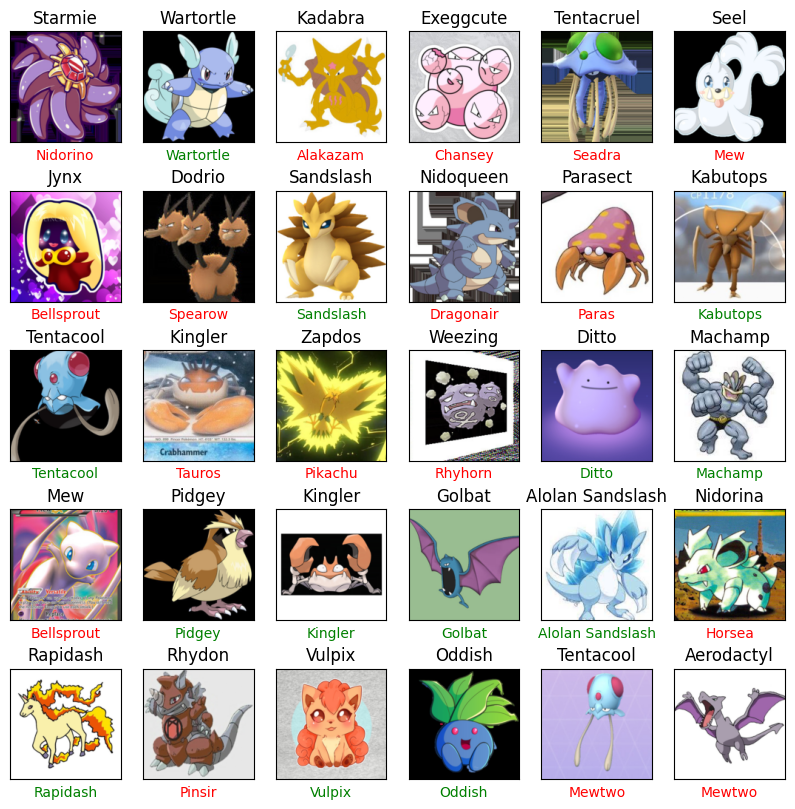

In [ ]:
evaluate_model(test_loader, saved_model)

In [ ]:
test_loader = DataLoader(test, batch_size=BATCH_SIZE)
correct_preds, incorrect_preds = get_correct_incorrect(test_loader, threshold=0)

In [ ]:
len(incorrect_preds), len(correct_preds)

(714, 650)

since our f1 score results are pretty low for the test and validation set we could:

1.   Try to add more layers to the model - reshaping the architecture
2.   Try to change the learning rate
3.   Try to train the model for more epochs at each fold

## Trying to improve our first neural network

### Set up Neptune for second CNN

In [40]:
hyperParameters = {
            'max_epochs':EPOCHS,
            'batch_size':BATCH_SIZE,
            'learning_rate':1e-5,
            'image_size': '150*150'
        }

In [41]:
neptune_logger = NeptuneLogger(
        api_key='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vbmV3LXVpLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9uZXctdWkubmVwdHVuZS5haSIsImFwaV9rZXkiOiIxYTUwNmZiMi1lNWI1LTRhM2MtOWIyMS1mZDhhYTZjMTg5MmEifQ==',
        project="Deep-Learning-Projects/Pokemon-Data",
        log_model_checkpoints=False,  
        tags=['CNN_Pokemon2']   
    )

In [42]:
neptune_logger.log_hyperparams(hyperParameters)

https://new-ui.neptune.ai/Deep-Learning-Projects/Pokemon-Data/e/POK-146
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


### Changing the learning rate of the model 

In [44]:
data_path = ""

class CNN_Pokemon2(L.LightningModule):
    def __init__(self, data_dir=data_path, num_classes=150, learning_rate=1e-5):
        super().__init__()

        # Set our init args as class attributes
        self.data_dir = data_dir
        self.learning_rate = learning_rate

        # Hardcode some dataset specific attributes
        self.num_classes = num_classes
        self.conv1 = nn.Conv2d(3,32,3,padding='same') 
        ## input channels 3 for rgb 
        ## output channels 32 - as the number of filters that we train
        ## kernel size 3 - arbitrary selection
        self.conv2 = nn.Conv2d(32,64,3,padding='same')
        self.conv3 = nn.Conv2d(64,128,3,padding='same')
        self.conv4 = nn.Conv2d(128,256,3,padding='same')
        self.linear1 = nn.Linear(256*37*37,350)
        self.linear2 = nn.Linear(350,self.num_classes)
        self.mp = nn.MaxPool2d(2,2)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(p=0.5)
        self.train_accuracy = torchmetrics.classification.F1Score(task="multiclass", num_classes=self.num_classes)
        self.val_accuracy = torchmetrics.classification.F1Score(task="multiclass", num_classes=self.num_classes)
        self.test_accuracy = torchmetrics.classification.F1Score(task="multiclass", num_classes=self.num_classes)


    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.mp(x)
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.mp(x)
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.linear2(x)
        return F.log_softmax(x, dim=1)

    def training_step(self, batch, batch_idx): 
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = argmax(logits, dim=1)
        self.train_accuracy.update(preds, y)
        self.log(f'training/{self.trainer.current_fold}/loss', loss, on_epoch=True, on_step=True)
        self.log(f'training/{self.trainer.current_fold}/train_acc', self.train_accuracy, on_epoch=True, on_step=True)
        return {'loss': loss, 'train_acc': self.train_accuracy.compute()} 

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = argmax(logits, dim=1)
        self.val_accuracy.update(preds, y)
        self.log(f'validation/{self.trainer.current_fold}/val_loss', loss, on_epoch=True, on_step=True)
        self.log(f'validation/{self.trainer.current_fold}/val_acc', self.val_accuracy, on_epoch=True, on_step=True)
        return {'val_loss': loss, 'val_acc': self.val_accuracy.compute()}       

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = argmax(logits, dim=1)
        self.test_accuracy.update(preds, y)
        self.log(f'test/{self.trainer.current_fold}/test_loss', loss, on_epoch=True, on_step=True)
        self.log(f'test/{self.trainer.current_fold}/test_acc', self.test_accuracy, on_epoch=True, on_step=True)
        return {'test_loss': loss, 'test_acc': self.test_accuracy.compute()}

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

### Run k-fold second model

In [ ]:
model = CNN_Pokemon2(num_classes=151)
accuracies_and_losses = cross_validation(train, test, labels_tensor, model, neptune_logger)

----------------------------------------
fold  0
----------------------------------------
Reset trainable parameters of layer = Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
Reset trainable parameters of layer = Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
Reset trainable parameters of layer = Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
Reset trainable parameters of layer = Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
Reset trainable parameters of layer = Linear(in_features=350464, out_features=350, bias=True)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Reset trainable parameters of layer = Linear(in_features=350, out_features=151, bias=True)


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name           | Type              | Params
------------------------------------------------------
0  | conv1          | Conv2d            | 896   
1  | conv2          | Conv2d            | 18.5 K
2  | conv3          | Conv2d            | 73.9 K
3  | conv4          | Conv2d            | 295 K 
4  | linear1        | Linear            | 122 M 
5  | linear2        | Linear            | 53.0 K
6  | mp             | MaxPool2d         | 0     
7  | relu           | ReLU              | 0     
8  | flatten        | Flatten           | 0     
9  | dropout        | Dropout           | 0     
10 | train_accuracy | MulticlassF1Score | 0     
11 | val_accuracy   | MulticlassF1Score | 0     
12 | test_accuracy  | MulticlassF1Score | 0     
------------------------------------------------------
123 M     Trainable params
0         Non-trainable params
123 M   

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
neptune_logger.experiment.stop()

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 4 operations to synchronize with Neptune. Do not kill this process.
All 4 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://new-ui.neptune.ai/Deep-Learning-Projects/Pokemon-Data/e/POK-116


In [ ]:
# save the model
torch.save(model.state_dict(), 'CNN_Pokemon2.pth')

### Comapring the data

In [ ]:
run = neptune.init_run(api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vbmV3LXVpLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9uZXctdWkubmVwdHVuZS5haSIsImFwaV9rZXkiOiIxYTUwNmZiMi1lNWI1LTRhM2MtOWIyMS1mZDhhYTZjMTg5MmEifQ==',
        project="Deep-Learning-Projects/Pokemon-Data",
        with_id="POK-116")

https://new-ui.neptune.ai/Deep-Learning-Projects/Pokemon-Data/e/POK-116
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [ ]:
validation_acc_data = run["training/validation/1/val_acc_epoch"].fetch_values(include_timestamp=False)
training_acc_data = run["training/training/1/train_acc_epoch"].fetch_values(include_timestamp=False)

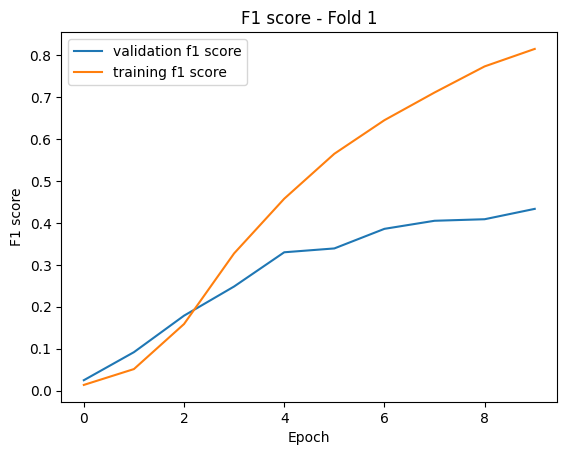

In [ ]:
plt.plot(validation_acc_data['value'], label='validation f1 score')
plt.plot(training_acc_data['value'], label='training f1 score')
plt.xlabel('Epoch')
plt.ylabel('F1 score')
plt.title('F1 score - Fold 1')
plt.legend()
plt.show()

In [ ]:
validation_loss_data = run["training/validation/1/val_loss_epoch"].fetch_values(include_timestamp=False)
training_loss_data = run["training/training/1/loss_epoch"].fetch_values(include_timestamp=False)

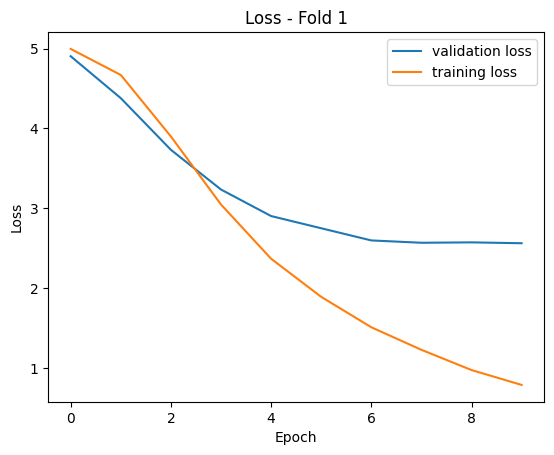

In [ ]:
plt.plot(validation_loss_data['value'], label='validation loss')
plt.plot(training_loss_data['value'], label='training loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss - Fold 1')
plt.legend()
plt.show()

Examples of good and bad samples:

In [ ]:
# Mount your Google Drive in Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# load the saved model
saved_model = CNN_Pokemon2()
saved_model.load_state_dict(torch.load('/content/drive/MyDrive/models/CNN_Pokemon2.pth'))

<All keys matched successfully>

In [ ]:
test_loader = DataLoader(test, batch_size=BATCH_SIZE)
correct_preds, incorrect_preds = get_correct_incorrect(test_loader, model)

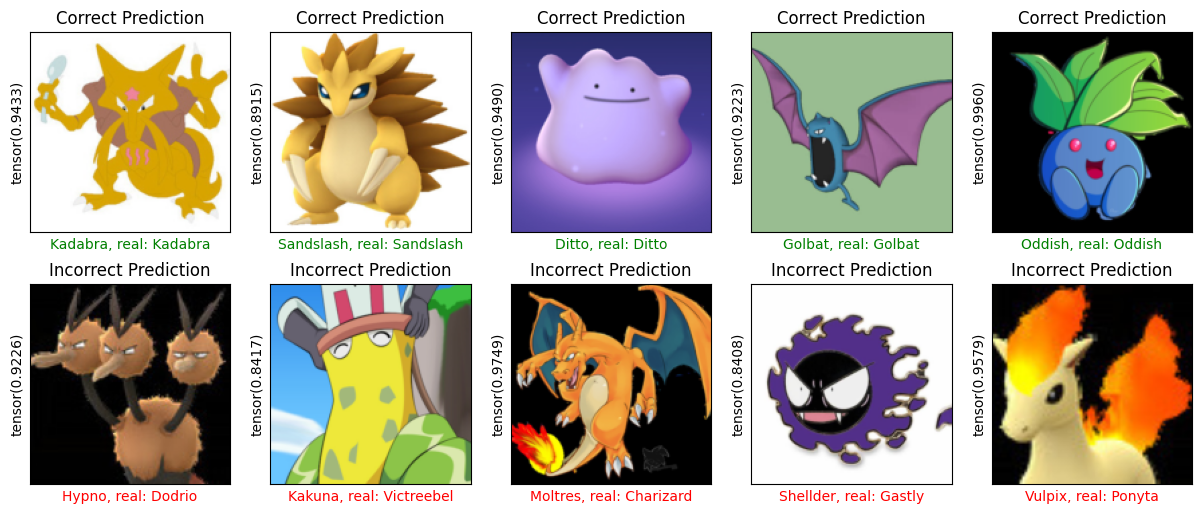

In [ ]:
visualize_correct_incorrect(correct_preds, incorrect_preds)

In [ ]:
visualize_measures(run)

---fold 0 validation f1 score---
   step     value
0   0.0  0.042125
1   1.0  0.104396
2   2.0  0.144689
3   3.0  0.232601
4   4.0  0.257326
5   5.0  0.297619
6   6.0  0.300366
7   7.0  0.312271
8   8.0  0.326923
9   9.0  0.358059
---fold 0 training f1 score---
   step     value
0   0.0  0.012603
1   1.0  0.055454
2   2.0  0.155820
3   3.0  0.289184
4   4.0  0.421632
5   5.0  0.514207
6   6.0  0.610907
7   7.0  0.684922
8   8.0  0.756187
9   9.0  0.817369
---fold 0 training loss---
   step     value
0   0.0  4.989126
1   1.0  4.613976
2   2.0  3.900181
3   3.0  3.181368
4   4.0  2.577232
5   5.0  2.080477
6   6.0  1.683421
7   7.0  1.360603
8   8.0  1.057919
9   9.0  0.826950
---fold 0 validation loss---
   step     value
0   0.0  4.881530
1   1.0  4.334240
2   2.0  3.818358
3   3.0  3.446860
4   4.0  3.248666
5   5.0  3.179897
6   6.0  3.165920
7   7.0  3.141859
8   8.0  3.082214
9   9.0  3.050265
---fold 1 validation f1 score---
   step     value
0   0.0  0.024748
1   1.0  0.091659
2

In [ ]:
test_accuracy_folds = []
for i in range(K):
  test_accuracy_fold = run[f"training/test/{i}/test_acc_epoch"].fetch_values(include_timestamp=False)
  test_accuracy_folds.append(test_accuracy_fold['value'][0])

In [ ]:
test_accuracy_mean = sum(test_accuracy_folds)/len(test_accuracy_folds)

In [ ]:
test_accuracy_mean

0.39017595648765563

In [ ]:
test_accuracy_folds.append(test_accuracy_mean)

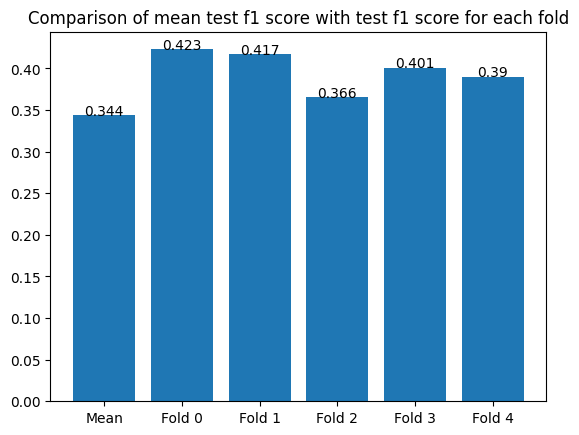

In [ ]:
plt.bar(['Mean', 'Fold 0', 'Fold 1', 'Fold 2', 'Fold 3', 'Fold 4'], test_accuracy_folds)
plt.title('Comparison of mean test f1 score with test f1 score for each fold')
for i in range(len(test_accuracy_folds)):
  plt.text(i,test_accuracy_folds[i],round(test_accuracy_folds[i], 3), ha='center')
plt.show()

### Misclassification and ways to improve

In [ ]:
test_loader = DataLoader(test, batch_size=BATCH_SIZE)

In [ ]:
evaluate_model(test_loader, saved_model)

In [ ]:
test_loader = DataLoader(test, batch_size=BATCH_SIZE)
correct_preds, incorrect_preds = get_correct_incorrect(test_loader, saved_model, threshold=0)

In [ ]:
len(incorrect_preds), len(correct_preds)

(817, 547)

### Set up Neptune for third CNN

In [ ]:
EPOCHS = 10
BATCH_SIZE = 32

In [ ]:
hyperParameters = {
            'max_epochs':EPOCHS,
            'batch_size':BATCH_SIZE,
            'learning_rate':1e-4,
            'loss_func': 'cross_entropy'
        }

In [ ]:
neptune_logger = NeptuneLogger(
        api_key='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vbmV3LXVpLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9uZXctdWkubmVwdHVuZS5haSIsImFwaV9rZXkiOiIxYTUwNmZiMi1lNWI1LTRhM2MtOWIyMS1mZDhhYTZjMTg5MmEifQ==',
        project="Deep-Learning-Projects/Pokemon-Data",
        log_model_checkpoints=False,       
    )

In [ ]:
neptune_logger.log_hyperparams(hyperParameters)

https://new-ui.neptune.ai/Deep-Learning-Projects/Pokemon-Data/e/POK-140
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


### Changing the loss function + image size + more complex model

In [ ]:
imagenet_data = datasets.ImageFolder("/content/PokemonData", transform=transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
]))

In [ ]:
train, test = random_split(imagenet_data, [0.8, 0.2], Generator().manual_seed(42))

In [ ]:
features_and_labels = get_features_labels(train)

In [ ]:
features_tensor = features_and_labels[0]
labels_tensor = features_and_labels[1]

In [ ]:
data_path=''

class CNN_Pokemon3(L.LightningModule):
    def __init__(self, data_dir=data_path, num_classes=150, learning_rate=1e-4):
        super().__init__()

        # Set our init args as class attributes
        self.data_dir = data_dir
        self.learning_rate = learning_rate

        # Hardcode some dataset specific attributes
        self.num_classes = num_classes
        self.conv1 = nn.Conv2d(3,32,3,padding='same') 
        ## input channels 3 for rgb 
        ## output channels 32 - as the number of filters that we train
        ## kernel size 3 - arbitrary selection
        self.conv2 = nn.Conv2d(32,64,3,padding='same')
        self.conv3 = nn.Conv2d(64,128,3,padding='same')
        self.conv4 = nn.Conv2d(128,256,3,padding='same')
        self.linear1 = nn.Linear(256*32*32,300)
        self.linear2 = nn.Linear(300,self.num_classes)
        self.mp = nn.MaxPool2d(2,2)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(p=0.5)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.train_accuracy = torchmetrics.classification.F1Score(task="multiclass", num_classes=150)
        self.val_accuracy = torchmetrics.classification.F1Score(task="multiclass", num_classes=150)
        self.test_accuracy = torchmetrics.classification.F1Score(task="multiclass", num_classes=150)


    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.mp(x)
        x = self.relu(self.bn2(self.conv2(x)))
        # x = self.relu(self.conv1(x))
        # x = self.relu(self.conv2(x))
        x = self.mp(x)
        x = self.relu(self.conv3(x))
        x = self.mp(x)
        x = self.relu(self.conv4(x))
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.linear2(x)
        return F.log_softmax(x, dim=1)

    def training_step(self, batch, batch_idx): 
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        preds = argmax(logits, dim=1)
        self.train_accuracy.update(preds, y)
        self.log(f'training/{self.trainer.current_fold}/loss', loss, on_epoch=True, on_step=True)
        self.log(f'training/{self.trainer.current_fold}/train_acc', self.train_accuracy, on_epoch=True, on_step=True)
        return {'loss': loss, 'train_acc': self.train_accuracy.compute()} 

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        preds = argmax(logits, dim=1)
        self.val_accuracy.update(preds, y)
        self.log(f'validation/{self.trainer.current_fold}/val_loss', loss, on_epoch=True, on_step=True)
        self.log(f'validation/{self.trainer.current_fold}/val_acc', self.val_accuracy, on_epoch=True, on_step=True)
        return {'val_loss': loss, 'val_acc': self.val_accuracy.compute()}       

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        preds = argmax(logits, dim=1)
        self.test_accuracy.update(preds, y)
        self.log(f'test/{self.trainer.current_fold}/test_loss', loss, on_epoch=True, on_step=True)
        self.log(f'test/{self.trainer.current_fold}/test_acc', self.test_accuracy, on_epoch=True, on_step=True)
        return {'test_loss': loss, 'test_acc': self.test_accuracy.compute()}

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer


### Run k-fold on third model

In [ ]:
model = CNN_Pokemon3()
accuracies_and_losses = cross_validation(train, test, labels_tensor, model, neptune_logger)

----------------------------------------
fold  0
----------------------------------------
Reset trainable parameters of layer = Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
Reset trainable parameters of layer = Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
Reset trainable parameters of layer = Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
Reset trainable parameters of layer = Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
Reset trainable parameters of layer = Linear(in_features=262144, out_features=300, bias=True)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name           | Type              | Params
------------------------------------------------------
0  | conv1          | Conv2d            | 896   
1  | conv2          | Conv2d            | 18.5 K
2  | conv3          | Conv2d            | 73.9 K
3  | conv4          | Conv2d            | 295 K 
4  | linear1        | Linear            | 78.6 M
5  | linear2        | Linear            | 45.1 K
6  | mp             | MaxPool2d         | 0     
7  | relu           | ReLU              | 0     
8  | flatten        | Flatten           | 

Reset trainable parameters of layer = Linear(in_features=300, out_features=150, bias=True)
Reset trainable parameters of layer = BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   test/0/test_acc_epoch   │    0.5227272510528564     │
│  test/0/test_loss_epoch   │    2.3740315437316895     │
└───────────────────────────┴───────────────────────────┘

----------------------------------------
train loss:  tensor(0.0349)
train accuracy:  tensor(0.9966)
validation loss:  tensor(2.3577)
validation accuracy:  tensor(0.5037)
test loss:  tensor(2.3740)
test accuracy:  tensor(0.5227)
----------------------------------------
----------------------------------------
fold  1
----------------------------------------
Reset trainable parameters of layer = Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
Reset trainable parameters of layer = Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
Reset trainable parameters of layer = Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
Reset trainable parameters of layer = Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
Reset trainable parameters of layer = Linear(in_features=262144, out_features=300, bias=True)
Reset trainable parameters of layer = Linear(in_features=300, out_features=150, bias=True)
Reset trainable parameters of layer = BatchNo

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.9/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory /content/.neptune/Untitled/POK-140/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name           | Type              | Params
------------------------------------------------------
0  | conv1          | Conv2d            | 896   
1  | conv2          | Conv2d            | 18.5 K
2  | conv3          | Conv2d            | 73.9 K
3  | conv4  

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   test/1/test_acc_epoch   │    0.5256597995758057     │
│  test/1/test_loss_epoch   │     2.499772787094116     │
└───────────────────────────┴───────────────────────────┘

----------------------------------------
train loss:  tensor(0.0253)
train accuracy:  tensor(0.9963)
validation loss:  tensor(2.4269)
validation accuracy:  tensor(0.5435)
test loss:  tensor(2.4998)
test accuracy:  tensor(0.5257)
----------------------------------------
----------------------------------------
fold  2
----------------------------------------
Reset trainable parameters of layer = Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
Reset trainable parameters of layer = Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
Reset trainable parameters of layer = Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
Reset trainable parameters of layer = Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
Reset trainable parameters of layer = Linear(in_features=262144, out_features=300, bias=True)
Reset trainable parameters of layer = Linear(in_features=300, out_features=150, bias=True)
Reset trainable parameters of layer = BatchNo

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name           | Type              | Params
------------------------------------------------------
0  | conv1          | Conv2d            | 896   
1  | conv2          | Conv2d            | 18.5 K
2  | conv3          | Conv2d            | 73.9 K
3  | conv4          | Conv2d            | 295 K 
4  | linear1        | Linear            | 78.6 M
5  | linear2        | Linear            | 45.1 K
6  | mp             | MaxPool2d         | 0     
7  | relu           | ReLU              | 0     
8  | flatten        | Flatten           | 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   test/2/test_acc_epoch   │    0.5080645084381104     │
│  test/2/test_loss_epoch   │    2.5245511531829834     │
└───────────────────────────┴───────────────────────────┘

----------------------------------------
train loss:  tensor(0.0278)
train accuracy:  tensor(0.9975)
validation loss:  tensor(2.4720)
validation accuracy:  tensor(0.5234)
test loss:  tensor(2.5246)
test accuracy:  tensor(0.5081)
----------------------------------------
----------------------------------------
fold  3
----------------------------------------
Reset trainable parameters of layer = Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
Reset trainable parameters of layer = Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
Reset trainable parameters of layer = Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
Reset trainable parameters of layer = Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
Reset trainable parameters of layer = Linear(in_features=262144, out_features=300, bias=True)
Reset trainable parameters of layer = Linear(in_features=300, out_features=150, bias=True)
Reset trainable parameters of layer = BatchNo

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name           | Type              | Params
------------------------------------------------------
0  | conv1          | Conv2d            | 896   
1  | conv2          | Conv2d            | 18.5 K
2  | conv3          | Conv2d            | 73.9 K
3  | conv4          | Conv2d            | 295 K 
4  | linear1        | Linear            | 78.6 M
5  | linear2        | Linear            | 45.1 K
6  | mp             | MaxPool2d         | 0     
7  | relu           | ReLU              | 0     
8  | flatten        | Flatten           | 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   test/3/test_acc_epoch   │    0.5058650970458984     │
│  test/3/test_loss_epoch   │    2.3837502002716064     │
└───────────────────────────┴───────────────────────────┘

----------------------------------------
train loss:  tensor(0.0335)
train accuracy:  tensor(0.9975)
validation loss:  tensor(2.4062)
validation accuracy:  tensor(0.5142)
test loss:  tensor(2.3838)
test accuracy:  tensor(0.5059)
----------------------------------------
----------------------------------------
fold  4
----------------------------------------
Reset trainable parameters of layer = Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
Reset trainable parameters of layer = Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
Reset trainable parameters of layer = Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
Reset trainable parameters of layer = Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
Reset trainable parameters of layer = Linear(in_features=262144, out_features=300, bias=True)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Reset trainable parameters of layer = Linear(in_features=300, out_features=150, bias=True)
Reset trainable parameters of layer = BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name           | Type              | Params
------------------------------------------------------
0  | conv1          | Conv2d            | 896   
1  | conv2          | Conv2d            | 18.5 K
2  | conv3          | Conv2d            | 73.9 K
3  | conv4          | Conv2d            | 295 K 
4  | linear1        | Linear            | 78.6 M
5  | linear2        | Linear            | 45.1 K
6  | mp             | MaxPool2d         | 0     
7  | relu           | ReLU              | 0     
8  | flatten        | Flatten           | 0     
9  | dropout        | Dropout           | 0     
10 | bn1            | BatchNorm2d       | 64    
11 | bn2            | BatchNorm2d       | 128   
12 | train_accuracy | MulticlassF1Score | 0     
13 | val_accuracy   | MulticlassF1Score | 0     
14 | test_accuracy  | MulticlassF1Score | 0     
-----------------------

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   test/4/test_acc_epoch   │    0.5175952911376953     │
│  test/4/test_loss_epoch   │    2.3811838626861572     │
└───────────────────────────┴───────────────────────────┘

----------------------------------------
train loss:  tensor(0.0488)
train accuracy:  tensor(0.9938)
validation loss:  tensor(2.2040)
validation accuracy:  tensor(0.5417)
test loss:  tensor(2.3812)
test accuracy:  tensor(0.5176)
----------------------------------------


In [ ]:
neptune_logger.experiment.stop()

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
All 1 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://new-ui.neptune.ai/Deep-Learning-Projects/Pokemon-Data/e/POK-140


In [ ]:
# save the model
torch.save(model.state_dict(), 'CNN_Pokemon3.pth')

### Comapring the data

In [ ]:
run = neptune.init_run(api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vbmV3LXVpLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9uZXctdWkubmVwdHVuZS5haSIsImFwaV9rZXkiOiIxYTUwNmZiMi1lNWI1LTRhM2MtOWIyMS1mZDhhYTZjMTg5MmEifQ==',
        project="Deep-Learning-Projects/Pokemon-Data",
        with_id="POK-140")

https://new-ui.neptune.ai/Deep-Learning-Projects/Pokemon-Data/e/POK-140
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [ ]:
validation_acc_data = run["training/validation/1/val_acc_epoch"].fetch_values(include_timestamp=False)
training_acc_data = run["training/training/1/train_acc_epoch"].fetch_values(include_timestamp=False)

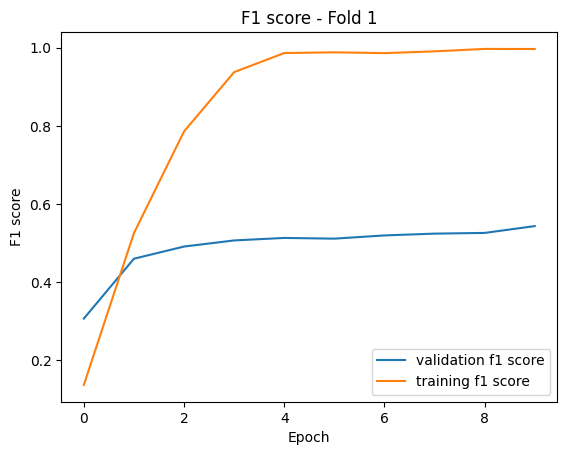

In [ ]:
plt.plot(validation_acc_data['value'], label='validation f1 score')
plt.plot(training_acc_data['value'], label='training f1 score')
plt.xlabel('Epoch')
plt.ylabel('F1 score')
plt.title('F1 score - Fold 1')
plt.legend()
plt.show()

In [ ]:
validation_loss_data = run["training/validation/1/val_loss_epoch"].fetch_values(include_timestamp=False)
training_loss_data = run["training/training/1/loss_epoch"].fetch_values(include_timestamp=False)

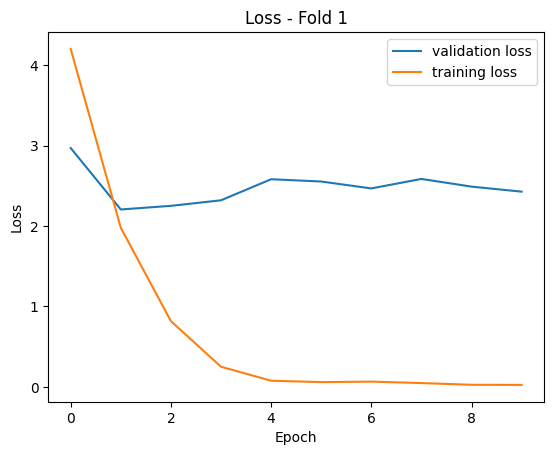

In [ ]:
plt.plot(validation_loss_data['value'], label='validation loss')
plt.plot(training_loss_data['value'], label='training loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss - Fold 1')
plt.legend()
plt.show()

Examples of good and bad samples:

In [ ]:
# Mount your Google Drive in Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# load the saved model
saved_model = CNN_Pokemon3()
saved_model.load_state_dict(torch.load('/content/drive/MyDrive/models/CNN_Pokemon3.pth'))

<All keys matched successfully>

In [ ]:
test_loader = DataLoader(test, batch_size=32)
correct_preds, incorrect_preds = get_correct_incorrect(test_loader, saved_model)

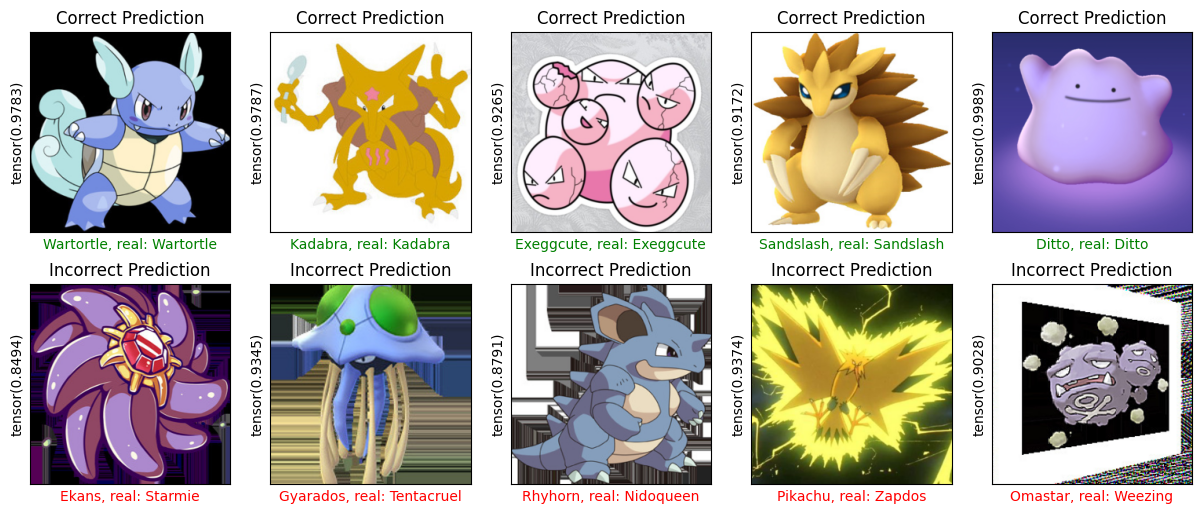

In [ ]:
visualize_correct_incorrect(correct_preds, incorrect_preds)

In [ ]:
visualize_measures(run)

---fold 0 validation f1 score---
   step     value
0   0.0  0.312271
1   1.0  0.457875
2   2.0  0.478022
3   3.0  0.477106
4   4.0  0.492674
5   5.0  0.481685
6   6.0  0.491758
7   7.0  0.509158
8   8.0  0.511905
9   9.0  0.503663
---fold 0 training f1 score---
   step     value
0   0.0  0.110220
1   1.0  0.550183
2   2.0  0.870990
3   3.0  0.966774
4   4.0  0.988084
5   5.0  0.991522
6   6.0  0.994042
7   7.0  0.994271
8   8.0  0.996563
9   9.0  0.996563
---fold 0 training loss---
   step     value
0   0.0  4.308762
1   1.0  1.877292
2   2.0  0.534059
3   3.0  0.172067
4   4.0  0.068156
5   5.0  0.062771
6   6.0  0.056937
7   7.0  0.052201
8   8.0  0.051648
9   9.0  0.034926
---fold 0 validation loss---
   step     value
0   0.0  3.092510
1   1.0  2.335562
2   2.0  2.386943
3   3.0  2.526818
4   4.0  2.552399
5   5.0  2.491394
6   6.0  2.431584
7   7.0  2.464806
8   8.0  2.261301
9   9.0  2.357686
---fold 1 validation f1 score---
   step     value
0   0.0  0.307058
1   1.0  0.460128
2

In [ ]:
test_accuracy_folds = []
for i in range(K):
  test_accuracy_fold = run[f"training/test/{i}/test_acc_epoch"].fetch_values(include_timestamp=False)
  test_accuracy_folds.append(test_accuracy_fold['value'][0])

In [ ]:
test_accuracy_mean = sum(test_accuracy_folds)/len(test_accuracy_folds)

In [ ]:
test_accuracy_mean

0.5159823894500732

In [ ]:
test_accuracy_folds.append(test_accuracy_mean)

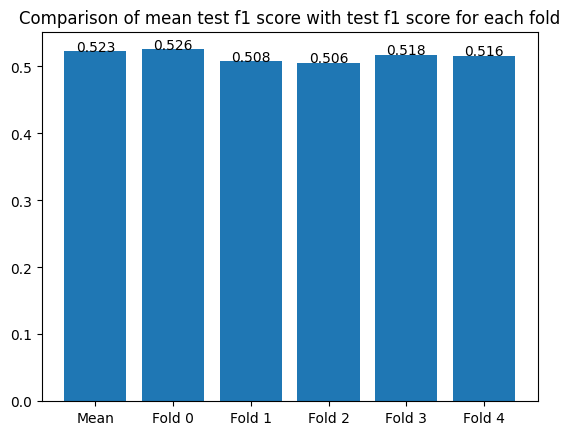

In [ ]:
plt.bar(['Mean', 'Fold 0', 'Fold 1', 'Fold 2', 'Fold 3', 'Fold 4'], test_accuracy_folds)
plt.title('Comparison of mean test f1 score with test f1 score for each fold')
for i in range(len(test_accuracy_folds)):
  plt.text(i,test_accuracy_folds[i],round(test_accuracy_folds[i], 3), ha='center')
plt.show()

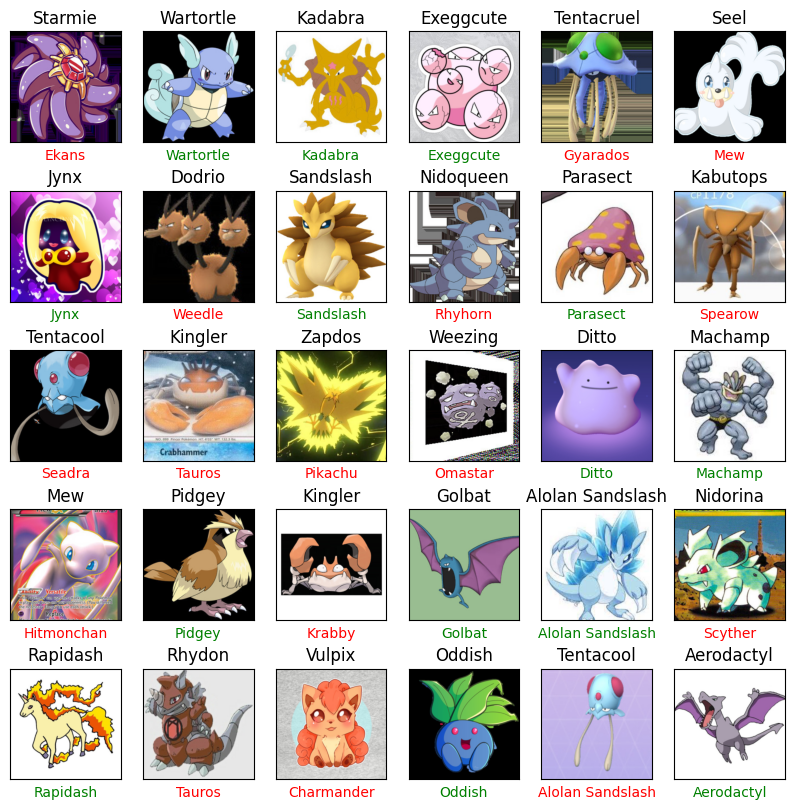

In [ ]:
test_loader = DataLoader(test, batch_size=32)
evaluate_model(test_loader, saved_model)

In [ ]:
correct_preds, incorrect_preds = get_correct_incorrect(test_loader, saved_model, threshold=0)

In [ ]:
len(correct_preds), len(incorrect_preds)

(707, 657)

### Implementing inference-time-augmentation 

In [ ]:
imagenet_data = datasets.ImageFolder("/content/PokemonData", transform=transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
]))

In [ ]:
train, test = random_split(imagenet_data, [0.8, 0.2], Generator().manual_seed(42))

In [ ]:
data_path=''

class CNN_Pokemon4(L.LightningModule):
    def __init__(self, data_dir=data_path, num_classes=150, learning_rate=1e-4):
        super().__init__()

        # Set our init args as class attributes
        self.data_dir = data_dir
        self.learning_rate = learning_rate

        # Hardcode some dataset specific attributes
        self.num_classes = num_classes
        self.conv1 = nn.Conv2d(3,32,3,padding='same') 
        ## input channels 3 for rgb 
        ## output channels 32 - as the number of filters that we train
        ## kernel size 3 - arbitrary selection
        self.conv2 = nn.Conv2d(32,64,3,padding='same')
        self.conv3 = nn.Conv2d(64,128,3,padding='same')
        self.conv4 = nn.Conv2d(128,256,3,padding='same')
        self.linear1 = nn.Linear(256*32*32,300)
        self.linear2 = nn.Linear(300,self.num_classes)
        self.mp = nn.MaxPool2d(2,2)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(p=0.5)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.train_accuracy = torchmetrics.classification.F1Score(task="multiclass", num_classes=150)
        self.val_accuracy = torchmetrics.classification.F1Score(task="multiclass", num_classes=150)
        self.test_accuracy = torchmetrics.classification.F1Score(task="multiclass", num_classes=150)


    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.mp(x)
        x = self.relu(self.bn2(self.conv2(x)))
        # x = self.relu(self.conv1(x))
        # x = self.relu(self.conv2(x))
        x = self.mp(x)
        x = self.relu(self.conv3(x))
        x = self.mp(x)
        x = self.relu(self.conv4(x))
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.linear2(x)
        return F.log_softmax(x, dim=1)

    def training_step(self, batch, batch_idx): 
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        preds = argmax(logits, dim=1)
        self.train_accuracy.update(preds, y)
        self.log(f'training/{self.trainer.current_fold}/loss', loss, on_epoch=True, on_step=True)
        self.log(f'training/{self.trainer.current_fold}/train_acc', self.train_accuracy, on_epoch=True, on_step=True)
        return {'loss': loss, 'train_acc': self.train_accuracy.compute()} 

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        preds = argmax(logits, dim=1)
        self.val_accuracy.update(preds, y)
        self.log(f'validation/{self.trainer.current_fold}/val_loss', loss, on_epoch=True, on_step=True)
        self.log(f'validation/{self.trainer.current_fold}/val_acc', self.val_accuracy, on_epoch=True, on_step=True)
        return {'val_loss': loss, 'val_acc': self.val_accuracy.compute()}       

    def test_step(self, batch, batch_idx):
        x, y = batch
        all_logits = []
        for i in range(4):
          flip = transforms.RandomHorizontalFlip(p=0.5)
          x_aug = flip(x)
          augment_logits = self(x_aug)
          all_logits.append(augment_logits)
        logits = torch.mean(torch.stack(all_logits), dim=0)
        loss = F.cross_entropy(logits, y)
        preds = argmax(logits, dim=1)
        self.test_accuracy.update(preds, y)
        # self.log(f'test/{self.trainer.current_fold}/test_loss', loss, on_epoch=True, on_step=True)
        # self.log(f'test/{self.trainer.current_fold}/test_acc', self.test_accuracy, on_epoch=True, on_step=True)
        self.log(f'test/test_loss', loss, on_epoch=True, on_step=True)
        self.log(f'test/test_acc', self.test_accuracy, on_epoch=True, on_step=True)
        return {'test_loss': loss, 'test_acc': self.test_accuracy.compute()}

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer


In [ ]:
# load the saved model
saved_model = CNN_Pokemon4()
saved_model.load_state_dict(torch.load('/content/drive/MyDrive/models/CNN_Pokemon3.pth'))

<All keys matched successfully>

In [ ]:
trainer = L.Trainer()
test_loader = DataLoader(test, batch_size=32)
trainer.test(saved_model, dataloaders=test_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/test_acc_epoch    │    0.5256597995758057     │
│   test/test_loss_epoch    │     2.252021074295044     │
└───────────────────────────┴───────────────────────────┘

[{'test/test_loss_epoch': 2.252021074295044,
  'test/test_acc_epoch': 0.5256597995758057}]

### Adding a new category

In [25]:
# !rm -r '/content/PokemonData/.ipynb_checkpoints'

In [ ]:
imagenet_data = datasets.ImageFolder("/content/PokemonData", transform=transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
]))
train, test = random_split(imagenet_data, [0.8, 0.2], Generator().manual_seed(42))

In [ ]:
features_and_labels = get_features_labels(train)

In [ ]:
features_tensor = features_and_labels[0]
labels_tensor = features_and_labels[1]

In [ ]:
neptune_logger = NeptuneLogger(
        api_key='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vbmV3LXVpLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9uZXctdWkubmVwdHVuZS5haSIsImFwaV9rZXkiOiIxYTUwNmZiMi1lNWI1LTRhM2MtOWIyMS1mZDhhYTZjMTg5MmEifQ==',
        project="Deep-Learning-Projects/Pokemon-Data",
        log_model_checkpoints=False,       
    )

In [ ]:
data_path=''

class CNN_Pokemon5(L.LightningModule):
    def __init__(self, data_dir=data_path, num_classes=151, learning_rate=1e-4):
        super().__init__()

        # Set our init args as class attributes
        self.data_dir = data_dir
        self.learning_rate = learning_rate

        # Hardcode some dataset specific attributes
        self.num_classes = num_classes
        self.conv1 = nn.Conv2d(3,32,3,padding='same') 
        ## input channels 3 for rgb 
        ## output channels 32 - as the number of filters that we train
        ## kernel size 3 - arbitrary selection
        self.conv2 = nn.Conv2d(32,64,3,padding='same')
        self.conv3 = nn.Conv2d(64,128,3,padding='same')
        self.conv4 = nn.Conv2d(128,256,3,padding='same')
        self.linear1 = nn.Linear(256*32*32,300)
        self.linear2 = nn.Linear(300,self.num_classes)
        self.mp = nn.MaxPool2d(2,2)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(p=0.5)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.train_accuracy = torchmetrics.classification.F1Score(task="multiclass", num_classes=self.num_classes)
        self.val_accuracy = torchmetrics.classification.F1Score(task="multiclass", num_classes=self.num_classes)
        self.test_accuracy = torchmetrics.classification.F1Score(task="multiclass", num_classes=self.num_classes)


    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.mp(x)
        x = self.relu(self.bn2(self.conv2(x)))
        # x = self.relu(self.conv1(x))
        # x = self.relu(self.conv2(x))
        x = self.mp(x)
        x = self.relu(self.conv3(x))
        x = self.mp(x)
        x = self.relu(self.conv4(x))
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.linear2(x)
        return F.log_softmax(x, dim=1)

    def training_step(self, batch, batch_idx): 
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        preds = argmax(logits, dim=1)
        self.train_accuracy.update(preds, y)
        self.log(f'training/{self.trainer.current_fold}/loss', loss, on_epoch=True, on_step=True)
        self.log(f'training/{self.trainer.current_fold}/train_acc', self.train_accuracy, on_epoch=True, on_step=True)
        return {'loss': loss, 'train_acc': self.train_accuracy.compute()} 

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        preds = argmax(logits, dim=1)
        self.val_accuracy.update(preds, y)
        self.log(f'validation/{self.trainer.current_fold}/val_loss', loss, on_epoch=True, on_step=True)
        self.log(f'validation/{self.trainer.current_fold}/val_acc', self.val_accuracy, on_epoch=True, on_step=True)
        return {'val_loss': loss, 'val_acc': self.val_accuracy.compute()}       

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        preds = argmax(logits, dim=1)
        self.test_accuracy.update(preds, y)
        self.log(f'test/{self.trainer.current_fold}/test_loss', loss, on_epoch=True, on_step=True)
        self.log(f'test/{self.trainer.current_fold}/test_acc', self.test_accuracy, on_epoch=True, on_step=True)
        return {'test_loss': loss, 'test_acc': self.test_accuracy.compute()}

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer


In [ ]:
model = CNN_Pokemon5()
accuracies_and_losses = cross_validation(train, test, labels_tensor, model, neptune_logger)

----------------------------------------
fold  0
----------------------------------------
Reset trainable parameters of layer = Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
Reset trainable parameters of layer = Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
Reset trainable parameters of layer = Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
Reset trainable parameters of layer = Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
Reset trainable parameters of layer = Linear(in_features=262144, out_features=300, bias=True)
Reset trainable parameters of layer = Linear(in_features=300, out_features=151, bias=True)
Reset trainable parameters of layer = BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name           | Type              | Params
------------------------------------------------------
0  | conv1          | Conv2d            | 896   
1  | conv2          | Conv2d            | 18.5 K
2  | conv3          | Conv2d            | 73.9 K
3  | conv4          | Conv2d            | 295 K 
4  | linear1        | Linear            | 78.6 M
5  | linear2        | Linear            | 45.5 K
6  | mp             | MaxPool2d         | 0     
7  | relu           | ReLU              | 0     
8  | flatten        | Flatten           | 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

https://new-ui.neptune.ai/Deep-Learning-Projects/Pokemon-Data/e/POK-141
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   test/0/test_acc_epoch   │    0.47406867146492004    │
│  test/0/test_loss_epoch   │     2.514874219894409     │
└───────────────────────────┴───────────────────────────┘

----------------------------------------
train loss:  tensor(0.0363)
train accuracy:  tensor(0.9943)
validation loss:  tensor(2.3892)
validation accuracy:  tensor(0.5046)
test loss:  tensor(2.5149)
test accuracy:  tensor(0.4741)
----------------------------------------
----------------------------------------
fold  1
----------------------------------------
Reset trainable parameters of layer = Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
Reset trainable parameters of layer = Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
Reset trainable parameters of layer = Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
Reset trainable parameters of layer = Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
Reset trainable parameters of layer = Linear(in_features=262144, out_features=300, bias=True)
Reset trainable parameters of layer = Linear(in_features=300, out_features=151, bias=True)
Reset trainable parameters of layer = BatchNo

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name           | Type              | Params
------------------------------------------------------
0  | conv1          | Conv2d            | 896   
1  | conv2          | Conv2d            | 18.5 K
2  | conv3          | Conv2d            | 73.9 K
3  | conv4          | Conv2d            | 295 K 
4  | linear1        | Linear            | 78.6 M
5  | linear2        | Linear            | 45.5 K
6  | mp             | MaxPool2d         | 0     
7  | relu           | ReLU              | 0     
8  | flatten        | Flatten           | 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   test/1/test_acc_epoch   │    0.4945215582847595     │
│  test/1/test_loss_epoch   │    2.6021311283111572     │
└───────────────────────────┴───────────────────────────┘

----------------------------------------
train loss:  tensor(0.0392)
train accuracy:  tensor(0.9941)
validation loss:  tensor(2.6185)
validation accuracy:  tensor(0.5132)
test loss:  tensor(2.6021)
test accuracy:  tensor(0.4945)
----------------------------------------
----------------------------------------
fold  2
----------------------------------------
Reset trainable parameters of layer = Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
Reset trainable parameters of layer = Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
Reset trainable parameters of layer = Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
Reset trainable parameters of layer = Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
Reset trainable parameters of layer = Linear(in_features=262144, out_features=300, bias=True)
Reset trainable parameters of layer = Linear(in_features=300, out_features=151, bias=True)
Reset trainable parameters of layer = BatchNo

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.9/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory /content/.neptune/Untitled/POK-141/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name           | Type              | Params
------------------------------------------------------
0  | conv1          | Conv2d            | 896   
1  | conv2          | Conv2d            | 18.5 K
2  | conv3          | Conv2d            | 73.9 K
3  | conv4  

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   test/2/test_acc_epoch   │    0.5339664220809937     │
│  test/2/test_loss_epoch   │     2.175682544708252     │
└───────────────────────────┴───────────────────────────┘

----------------------------------------
train loss:  tensor(0.0329)
train accuracy:  tensor(0.9966)
validation loss:  tensor(1.9960)
validation accuracy:  tensor(0.5671)
test loss:  tensor(2.1757)
test accuracy:  tensor(0.5340)
----------------------------------------
----------------------------------------
fold  3
----------------------------------------
Reset trainable parameters of layer = Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
Reset trainable parameters of layer = Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
Reset trainable parameters of layer = Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
Reset trainable parameters of layer = Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
Reset trainable parameters of layer = Linear(in_features=262144, out_features=300, bias=True)
Reset trainable parameters of layer = Linear(in_features=300, out_features=151, bias=True)
Reset trainable parameters of layer = BatchNo

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name           | Type              | Params
------------------------------------------------------
0  | conv1          | Conv2d            | 896   
1  | conv2          | Conv2d            | 18.5 K
2  | conv3          | Conv2d            | 73.9 K
3  | conv4          | Conv2d            | 295 K 
4  | linear1        | Linear            | 78.6 M
5  | linear2        | Linear            | 45.5 K
6  | mp             | MaxPool2d         | 0     
7  | relu           | ReLU              | 0     
8  | flatten        | Flatten           | 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   test/3/test_acc_epoch   │    0.5105916857719421     │
│  test/3/test_loss_epoch   │    2.3886921405792236     │
└───────────────────────────┴───────────────────────────┘

----------------------------------------
train loss:  tensor(0.0444)
train accuracy:  tensor(0.9929)
validation loss:  tensor(2.2783)
validation accuracy:  tensor(0.5087)
test loss:  tensor(2.3887)
test accuracy:  tensor(0.5106)
----------------------------------------
----------------------------------------
fold  4
----------------------------------------
Reset trainable parameters of layer = Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
Reset trainable parameters of layer = Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
Reset trainable parameters of layer = Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
Reset trainable parameters of layer = Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
Reset trainable parameters of layer = Linear(in_features=262144, out_features=300, bias=True)
Reset trainable parameters of layer = Linear(in_features=300, out_features=151, bias=True)
Reset trainable parameters of layer = BatchNo

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name           | Type              | Params
------------------------------------------------------
0  | conv1          | Conv2d            | 896   
1  | conv2          | Conv2d            | 18.5 K
2  | conv3          | Conv2d            | 73.9 K
3  | conv4          | Conv2d            | 295 K 
4  | linear1        | Linear            | 78.6 M
5  | linear2        | Linear            | 45.5 K
6  | mp             | MaxPool2d         | 0     
7  | relu           | ReLU              | 0     
8  | flatten        | Flatten           | 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   test/4/test_acc_epoch   │    0.5040175318717957     │
│  test/4/test_loss_epoch   │    2.6777522563934326     │
└───────────────────────────┴───────────────────────────┘

----------------------------------------
train loss:  tensor(0.0359)
train accuracy:  tensor(0.9927)
validation loss:  tensor(2.6549)
validation accuracy:  tensor(0.5160)
test loss:  tensor(2.6778)
test accuracy:  tensor(0.5040)
----------------------------------------


In [ ]:
test_loader = DataLoader(test, batch_size=BATCH_SIZE)

In [ ]:
correct_preds, incorrect_preds = get_correct_incorrect(test_loader, model, threshold=0)


In [ ]:
len(correct_preds), len(incorrect_preds)

(680, 689)

## Pretrained models

### Getting dataset ready

In [ ]:
BATCH_SIZE = 16

In [ ]:
imagenet_data = datasets.ImageFolder("/content/PokemonData", transform=transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
]))

In [ ]:
train, test = torch.utils.data.random_split(imagenet_data, [0.8, 0.2], torch.Generator().manual_seed(42))
train, validation = torch.utils.data.random_split(train, [0.8, 0.2], torch.Generator().manual_seed(42))

In [ ]:
train_loader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
def count_parameters(model):
  table = PrettyTable(["Mod name", "Parameters Listed"])
  t_params = 0
  for name, parameter in model.named_parameters():
    if not parameter.requires_grad: continue
    param = parameter.numel()
    table.add_row([name, param])
    t_params+=param
    print(table)
  print(f"Sum of trained paramters: {t_params}")
  return t_params

### Training loop

In [ ]:
# Train the model
def train_loop(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    '''returns the trained model'''
    
    # Initialize tracker for minimum validation loss
    valid_loss_min = np.inf
    start_time = time.time()

  
    for epoch in range(1, n_epochs+1):
        # In the training loop, I track down the loss
        # Initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        correct_train = 0.0
        total_train = 0.0
        correct_val = 0.0
        total_val = 0.0
    
        # Model training
        model.train()
        for batch_idx, (data,target) in enumerate(train_loader):
            # 1st step: Move to GPU
            if use_cuda:
                data,target = data.cuda(), target.cuda()
      
            # Then, clear (zero out) the gradient of all optimized variables
            optimizer.zero_grad()
            # Forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # Perform the Cross Entropy Loss. Calculate the batch loss.
            loss = criterion(output, target)
            # Backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # Perform optimization step (parameter update)
            optimizer.step()
            # Record the average training loss
            train_loss = train_loss + ((1/ (batch_idx + 1 ))*(loss.data-train_loss))

            # convert output probabilities to predicted class 
            pred_train = output.data.max(1, keepdim=True)[1]
            # compare predictions to original labels in training
            correct_train += np.sum(np.squeeze(pred_train.eq(target.data.view_as(pred_train))).cpu().numpy())
            total_train += data.size(0)
      
        # Model validation
        model.eval()
        for batch_idx, (data,target) in enumerate(validation_loader):
            # Move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            # Update the average validation loss
            # Forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # Calculate the batch loss
            loss = criterion(output, target)
            # Update the average validation loss
            valid_loss = valid_loss + ((1/ (batch_idx +1)) * (loss.data - valid_loss))


            # convert output probabilities to predicted class
            pred_val = output.data.max(1, keepdim=True)[1]
            # compare predictions to 
            correct_val += np.sum(np.squeeze(pred_val.eq(target.data.view_as(pred_val))).cpu().numpy())
            total_val += data.size(0)
                
      
        # print training/validation stats
        print('Epoch: {} \tTraining Loss: {:.5f} \tValidation Loss: {:.5f}'.format(
            epoch,
            train_loss,
            valid_loss))
    
        # Save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.5f} --> {:.5f}). Saving model ...'.format(
                  valid_loss_min,
                  valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
        
        print('train Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct_train / total_train, correct_train, total_train))
        print('val Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct_val / total_val, correct_val, total_val))


    print("--- %s train time --- \n" % (time.time() - start_time))

    # Return trained model
    return model

# Define loaders transfer
loaders_transfer = {'train': train_loader,
                    'valid': validation_loader,
                    'test': test_loader}


### Testing loop

In [ ]:
def test_loop(loaders, model, criterion, use_cuda):

    start_time = time.time()
    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.
    all_pred= np.empty((0,1),int)
    model_transfer.eval() #set model into evaluation/testing mode. It turns of drop off layer
    #Iterating over test data
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        
        all_pred = np.vstack((all_pred,pred.cpu().numpy()))
        # compare predictions to original labels in test
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
          
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))
    
    print("--- %s test time ---\n" % (time.time() - start_time))

    return all_pred


### Check Googlenet and Resnet50

In [ ]:
googlenet = models.googlenet(pretrained=True)
resnet50 = models.resnet50(pretrained=True)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 297MB/s]
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed 

In [ ]:
all_models_pred= np.empty((len(test),0 ),int)

In [ ]:
pre_models = [googlenet,resnet50] 
models_names = ['googlenet','resnet50']
all_models_pred= np.empty((len(test),0 ),int)


for i in range(len(pre_models)):
  model_transfer =pre_models[i]

  # Check if GPU is available
  use_cuda = torch.cuda.is_available()
  if use_cuda:
      model_transfer = model_transfer.cuda()

  for param in model_transfer.parameters():
      param.requires_grad=True
  # Define n_inputs takes the same number of inputs from pre-trained model
  n_inputs = model_transfer.fc.in_features #refer to the fully connected layer only

  # Add last linear layer (n_inputs -> 4 classes). In this case the ouput is 4 classes
  # New layer automatically has requires_grad = True
  last_layer = nn.Linear(n_inputs, 150)

  model_transfer.fc = last_layer

  # If GPU is available, move the model to GPU
  if use_cuda:
      model_transfer = model_transfer.cuda()
    
  # Check to see the last layer produces the expected number of outputs
  print(model_transfer.fc.out_features)

  criterion_transfer = nn.CrossEntropyLoss()
  optimizer_transfer = optim.SGD(model_transfer.parameters(), lr=0.001, momentum=0.9)


  model_pt = models_names[i]+'.pt'

  print(f'training model :{models_names[i]}')
  # Train the model
  model_transfer = train_loop(5, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, model_pt)
  summary(model_transfer, (3,150,150))

  # Load the model that got the best validation accuracy
  model_transfer.load_state_dict(torch.load(model_pt))

  # Test the model
  test_preds = test_loop(loaders_transfer,model_transfer, criterion_transfer, use_cuda)
  all_models_pred = np.append(all_models_pred, test_preds, axis=1)
  

150
training model :googlenet
Epoch: 1 	Training Loss: 3.53323 	Validation Loss: 2.29029
Validation loss decreased (inf --> 2.29029). Saving model ...
train Accuracy: 37% (1638/4365)
val Accuracy: 56% (621/1091)
Epoch: 2 	Training Loss: 1.64174 	Validation Loss: 1.47165
Validation loss decreased (2.29029 --> 1.47165). Saving model ...
train Accuracy: 76% (3346/4365)
val Accuracy: 69% (757/1091)
Epoch: 3 	Training Loss: 0.95699 	Validation Loss: 1.13292
Validation loss decreased (1.47165 --> 1.13292). Saving model ...
train Accuracy: 87% (3841/4365)
val Accuracy: 76% (831/1091)
Epoch: 4 	Training Loss: 0.61273 	Validation Loss: 0.95214
Validation loss decreased (1.13292 --> 0.95214). Saving model ...
train Accuracy: 93% (4098/4365)
val Accuracy: 78% (851/1091)
Epoch: 5 	Training Loss: 0.41042 	Validation Loss: 0.85375
Validation loss decreased (0.95214 --> 0.85375). Saving model ...
train Accuracy: 96% (4229/4365)
val Accuracy: 79% (870/1091)
--- 279.3764741420746 train time --- 

-----

### Check Densenet

In [ ]:
# Load pre-trained DenseNet model
densenet121 = models.densenet121(weights='IMAGENET1K_V1')

# Freeze all layers except the last one
# for param in densenet121.parameters():
#     param.requires_grad = False
# for param in densenet121.classifier.parameters():
#     param.requires_grad = True

# Replace last fully connected layer with new one
num_ftrs = densenet121.classifier.in_features
# densenet.classifier = nn.Linear(num_ftrs, 150)
# num_ftrs = densenet121.fc.in_features
densenet121.fc = nn.Linear(num_ftrs, 150)
criterion_transfer = nn.CrossEntropyLoss()
# optimizer_transfer = optim.SGD(densenet.parameters(), lr=0.0001, momentum=0.9)
optimizer_transfer = optim.Adam(densenet121.classifier.parameters(),lr= 3e-3)
model_pt ='densenet121.pt'
densenet121 = densenet121.cuda()

model_densenet121 = train_loop(5, loaders_transfer, densenet121, optimizer_transfer, criterion_transfer, use_cuda, model_pt)

Epoch: 1 	Training Loss: 4.48441 	Validation Loss: 1.81590
Validation loss decreased (inf --> 1.81590). Saving model ...
train Accuracy: 26% (1156/4365)
val Accuracy: 57% (625/1091)
Epoch: 2 	Training Loss: 0.64309 	Validation Loss: 1.39051
Validation loss decreased (1.81590 --> 1.39051). Saving model ...
train Accuracy: 83% (3651/4365)
val Accuracy: 66% (723/1091)
Epoch: 3 	Training Loss: 0.17488 	Validation Loss: 1.28544
Validation loss decreased (1.39051 --> 1.28544). Saving model ...
train Accuracy: 97% (4261/4365)
val Accuracy: 68% (750/1091)
Epoch: 4 	Training Loss: 0.06085 	Validation Loss: 1.18202
Validation loss decreased (1.28544 --> 1.18202). Saving model ...
train Accuracy: 99% (4356/4365)
val Accuracy: 72% (789/1091)
Epoch: 5 	Training Loss: 0.03022 	Validation Loss: 1.13404
Validation loss decreased (1.18202 --> 1.13404). Saving model ...
train Accuracy: 99% (4364/4365)
val Accuracy: 74% (810/1091)
--- 336.7050347328186 train time --- 



In [ ]:
densenet121_pred = test_loop(loaders_transfer,model_densenet121, criterion_transfer, use_cuda)
all_models_pred = np.append(all_models_pred, densenet121_pred, axis=1)

Test Loss: 1.087307


Test Accuracy: 73% (1005/1364)
--- 13.306646585464478 test time ---



In [ ]:
count_parameters(model_densenet121)

Streaming output truncated to the last 5000 lines.
|  features.denseblock2.denselayer5.norm2.bias   |        128        |
| features.denseblock2.denselayer5.conv2.weight  |       36864       |
| features.denseblock2.denselayer6.norm1.weight  |        288        |
|  features.denseblock2.denselayer6.norm1.bias   |        288        |
| features.denseblock2.denselayer6.conv1.weight  |       36864       |
| features.denseblock2.denselayer6.norm2.weight  |        128        |
|  features.denseblock2.denselayer6.norm2.bias   |        128        |
| features.denseblock2.denselayer6.conv2.weight  |       36864       |
| features.denseblock2.denselayer7.norm1.weight  |        320        |
|  features.denseblock2.denselayer7.norm1.bias   |        320        |
| features.denseblock2.denselayer7.conv1.weight  |       40960       |
| features.denseblock2.denselayer7.norm2.weight  |        128        |
|  features.denseblock2.denselayer7.norm2.bias   |        128        |
| features.denseblock2.den

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



+------------------------------------------------+-------------------+
|                    Mod name                    | Parameters Listed |
+------------------------------------------------+-------------------+
|             features.conv0.weight              |        9408       |
|             features.norm0.weight              |         64        |
|              features.norm0.bias               |         64        |
| features.denseblock1.denselayer1.norm1.weight  |         64        |
|  features.denseblock1.denselayer1.norm1.bias   |         64        |
| features.denseblock1.denselayer1.conv1.weight  |        8192       |
| features.denseblock1.denselayer1.norm2.weight  |        128        |
|  features.denseblock1.denselayer1.norm2.bias   |        128        |
| features.denseblock1.denselayer1.conv2.weight  |       36864       |
| features.denseblock1.denselayer2.norm1.weight  |         96        |
|  features.denseblock1.denselayer2.norm1.bias   |         96        |
| feat

8132606

### Check VGG16

In [ ]:
# Load pre-trained VGG-19 model
vgg16 = models.vgg16(weights='IMAGENET1K_V1')

# Freeze all layers except the last one
for param in vgg16.parameters():
    param.requires_grad = False
# for param in vgg19.classifier.parameters():
#     param.requires_grad = True

# Replace last fully connected layer with new one
num_ftrs = vgg16.classifier[-1].in_features
num_classes = 150
# vgg19.classifier[-1] = nn.Linear(num_ftrs, num_classes)
vgg16.classifier._modules['6'] = nn.Linear(4096, 150)
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.Adam(vgg16.classifier.parameters(),lr= 4e-3)
# optimizer_transfer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)
model_pt ='vgg19.pt'
vgg16 = vgg16.cuda()
vgg16_transfer = train_loop(5, loaders_transfer, vgg16, optimizer_transfer, criterion_transfer, use_cuda, model_pt)

Epoch: 1 	Training Loss: 5.89958 	Validation Loss: 3.98680
Validation loss decreased (inf --> 3.98680). Saving model ...
train Accuracy: 25% (1116/4365)
val Accuracy: 43% (473/1091)
Epoch: 2 	Training Loss: 3.68866 	Validation Loss: 4.21468
train Accuracy: 50% (2203/4365)
val Accuracy: 47% (519/1091)
Epoch: 3 	Training Loss: 2.99417 	Validation Loss: 4.37356
train Accuracy: 58% (2535/4365)
val Accuracy: 50% (548/1091)
Epoch: 4 	Training Loss: 2.62656 	Validation Loss: 4.91255
train Accuracy: 63% (2784/4365)
val Accuracy: 50% (547/1091)
Epoch: 5 	Training Loss: 2.40139 	Validation Loss: 5.17087
train Accuracy: 67% (2930/4365)
val Accuracy: 50% (548/1091)
--- 285.4955744743347 train time --- 



In [ ]:
vgg16_pred = test_loop(loaders_transfer,vgg16_transfer, criterion_transfer, use_cuda)
all_models_pred = np.append(all_models_pred, vgg16_pred, axis=1)

Test Loss: 4.723398


Test Accuracy: 54% (740/1364)
--- 13.644838809967041 test time ---



In [ ]:
summary(vgg16_transfer, (3,150,150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 150, 150]           1,792
              ReLU-2         [-1, 64, 150, 150]               0
            Conv2d-3         [-1, 64, 150, 150]          36,928
              ReLU-4         [-1, 64, 150, 150]               0
         MaxPool2d-5           [-1, 64, 75, 75]               0
            Conv2d-6          [-1, 128, 75, 75]          73,856
              ReLU-7          [-1, 128, 75, 75]               0
            Conv2d-8          [-1, 128, 75, 75]         147,584
              ReLU-9          [-1, 128, 75, 75]               0
        MaxPool2d-10          [-1, 128, 37, 37]               0
           Conv2d-11          [-1, 256, 37, 37]         295,168
             ReLU-12          [-1, 256, 37, 37]               0
           Conv2d-13          [-1, 256, 37, 37]         590,080
             ReLU-14          [-1, 256,

### Find unique classification and misclassifications

In [ ]:
test_features, test_labels = get_features_labels(test)

In [ ]:
np.append(all_models_pred, test_labels, axis=1)

In [ ]:
correct_count=(len(all_models_pred[0])-1)*[0]
worng_count = (len(all_models_pred[0])-1)*[0]

for i in range(len(all_models_pred)):
  true_val = all_models_pred[i][-1]
  is_correct =[]
  for j in range(0,len(all_models_pred[i])-1):
    if all_models_pred[i][j] == true_val:
      is_correct.append(j)
  if len(is_correct) == 1:
    correct_count[is_correct[0]] += 1
  is_worng =[]
  for j in range(0,len(all_models_pred[i])-1):
    if all_models_pred[i,j] != true_val:
      is_worng.append(j)
  if le

### Feature extraction

In [ ]:
# Load the pre-trained GoogleNet model
model = models.googlenet(pretrained=True)

# Remove the last classification layer
model.fc = nn.Identity()

model.eval()

dataset = imagenet_data
dataloader = torch.utils.data.DataLoader(imagenet_data, batch_size=32, shuffle=False)

# Extract features for each image in the dataset
features = []
with torch.no_grad():
    for images, labels in dataloader:
        # Pass the images through the model
        outputs = model(images)
        # Extract the features from the output
        features.append(outputs)

# Concatenate the features from all batches into a single tensor
features = torch.cat(features, dim=0)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:01<00:00, 41.7MB/s]


In [ ]:
imagenet_data_loader = torch.utils.data.DataLoader(imagenet_data, batch_size=32, shuffle=True)

In [ ]:
features_and_labels = get_features_labels(imagenet_data)

In [ ]:
labels_tensor = features_and_labels[1]

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features.numpy(), labels_tensor, test_size=0.2, random_state=42)

# Train a logistic regression classifier on the extracted features
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Evaluate the classifier on the test set
accuracy = clf.score(X_test, y_test)
print(f"Accuracy: {accuracy}")

Accuracy: 0.6876832844574781
